In [2]:
from __future__ import with_statement
import sys
import os
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd
import numpy as np
import scipy as sp
import random
import distance
import matplotlib.pyplot as plt
import matplotlib
import itertools
import seaborn as sns
import statsmodels.api as sm 
import warnings
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')
# plt.rcParams["font.family"] = 'Helvetica'

from stats import smooth
import stats
from plotutils import colormap_lch

from scipy.odr import Model, Data, ODR
from scipy.stats import linregress
from scipy.stats import nbinom

import rpy2.robjects.packages as packages
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
from adjustText import adjust_text
from sklearn.cluster import AgglomerativeClustering
import pickle
R = ro.r

%reload_ext rpy2.ipython
%matplotlib inline

In [3]:
plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

savedir = '/casa/jenny/notebooks/pan-viral_MPRA/paper_figures/'

In [4]:
%cd ~/basic/pan-viral/220602-polysomeMPRA_rep3/results/
%ls *bed

/casa/jenny/basic/pan-viral/220602-polysomeMPRA_rep3/results
Free.btw2.local.align.filter.bed
Free.btw2.local.align.filter.process.bed
HP.btw2.local.align.filter.bed
HP.btw2.local.align.filter.process.bed
Input.btw2.local.align.filter.bed
Input.btw2.local.align.filter.process.bed
LP.btw2.local.align.filter.bed
LP.btw2.local.align.filter.process.bed
Mono.btw2.local.align.filter.bed
Mono.btw2.local.align.filter.process.bed
MP.btw2.local.align.filter.bed
MP.btw2.local.align.filter.process.bed


In [5]:
def log_tf(x):
    return np.log2(x+1)


In [6]:
folder = '/casa/jenny/basic/pan-viral/220512-polysomeMPRA/results/'
colnames = ['Free','Mono','LP','MP','HP']
for i,s in enumerate(['Free','Mono','LP','MP','HP']): #['Syn-R1','Syn-R2','WC4','Syn-D1','Syn-D2','D4']):
    tmp = pd.read_csv(folder+'%s.btw2.local.align.filter.process.bed'%(s),sep=' ', names = ['alignid','count'])
#     tmp = tmp[tmp['qual']=='T']
#     tmp = tmp.groupby('alignid').count()['qual'].reset_index()
#     print(tmp.head())
    tmp.columns = ['alignid', 'count_%s'%(colnames[i])]
    print(s, tmp.shape, len(set(tmp['alignid'])))
    if i==0:
        countBC_merge_rep1 = tmp
    else:
        countBC_merge_rep1 = pd.merge(countBC_merge_rep1, tmp, how='outer', on='alignid').fillna(0)

countBC_merge_rep1['species'] = countBC_merge_rep1['alignid'].apply(lambda x: '|'.join(x.split('|')[:-2]))
countBC_merge_rep1['virus'] = countBC_merge_rep1['species'].apply(lambda x: x.split('|')[1])
countBC_merge_rep1['site'] = countBC_merge_rep1['species'].apply(lambda x: x.split('|')[3])
countBC_merge_rep1['uniqID'] = countBC_merge_rep1['species'].apply(lambda x: x.split('|')[0])

count_merge_rep1 = countBC_merge_rep1.groupby('species').sum().reset_index()
count_merge_rep1['virus'] = count_merge_rep1['species'].apply(lambda x: x.split('|')[1])
count_merge_rep1['site'] = count_merge_rep1['species'].apply(lambda x: x.split('|')[3])
count_merge_rep1['uniqID'] = count_merge_rep1['species'].apply(lambda x: x.split('|')[0])

count_merge_rep1.head()

Free (89427, 2) 89427
Mono (89772, 2) 89772
LP (89464, 2) 89464
MP (89556, 2) 89556
HP (89060, 2) 89060


,species,count_Free,count_Mono,count_LP,count_MP,count_HP,virus,site,uniqID
0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",403.0,352.0,370.0,575.0,482.0,ROTAVIRUS_A,"1,130",TILE_ID_001-00001
1,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",265.0,289.0,263.0,237.0,399.0,ROTAVIRUS_A,"66,195",TILE_ID_001-00002
2,"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,...",491.0,316.0,430.0,430.0,469.0,ROTAVIRUS_A,"131,260",TILE_ID_001-00003
3,"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,...",788.0,1083.0,882.0,994.0,807.0,ROTAVIRUS_A,"196,325",TILE_ID_001-00004
4,"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,...",374.0,262.0,199.0,375.0,320.0,ROTAVIRUS_A,"261,390",TILE_ID_001-00005


In [7]:
folder = '/casa/jenny/basic/pan-viral/220518-polysomeMPRA_rep2/results/'
colnames = ['Free','Mono','LP','MP','HP']
for i,s in enumerate(['Free','Mono','LP','MP','HP']): #['Syn-R1','Syn-R2','WC4','Syn-D1','Syn-D2','D4']):
    tmp = pd.read_csv(folder+'%s.btw2.local.align.filter.process.bed'%(s),sep=' ', names = ['alignid','count'])
#     tmp = tmp[tmp['qual']=='T']
#     tmp = tmp.groupby('alignid').count()['qual'].reset_index()
#     print(tmp.head())
    tmp.columns = ['alignid', 'count_%s'%(colnames[i])]
    print(s, tmp.shape, len(set(tmp['alignid'])))
    if i==0:
        countBC_merge_rep2 = tmp
    else:
        countBC_merge_rep2 = pd.merge(countBC_merge_rep2, tmp, how='outer', on='alignid').fillna(0)

countBC_merge_rep2['species'] = countBC_merge_rep2['alignid'].apply(lambda x: '|'.join(x.split('|')[:-2]))
countBC_merge_rep2['virus'] = countBC_merge_rep2['species'].apply(lambda x: x.split('|')[1])
countBC_merge_rep2['site'] = countBC_merge_rep2['species'].apply(lambda x: x.split('|')[3])
countBC_merge_rep2['uniqID'] = countBC_merge_rep2['species'].apply(lambda x: x.split('|')[0])

count_merge_rep2 = countBC_merge_rep2.groupby('species').sum().reset_index()
count_merge_rep2['virus'] = count_merge_rep2['species'].apply(lambda x: x.split('|')[1])
count_merge_rep2['site'] = count_merge_rep2['species'].apply(lambda x: x.split('|')[3])
count_merge_rep2['uniqID'] = count_merge_rep2['species'].apply(lambda x: x.split('|')[0])

count_merge_rep2.head()

Free (89287, 2) 89287
Mono (89727, 2) 89727
LP (89799, 2) 89799
MP (89558, 2) 89558
HP (89167, 2) 89167


,species,count_Free,count_Mono,count_LP,count_MP,count_HP,virus,site,uniqID
0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",339.0,276.0,348.0,328.0,382.0,ROTAVIRUS_A,"1,130",TILE_ID_001-00001
1,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",275.0,299.0,303.0,286.0,276.0,ROTAVIRUS_A,"66,195",TILE_ID_001-00002
2,"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,...",370.0,354.0,431.0,371.0,379.0,ROTAVIRUS_A,"131,260",TILE_ID_001-00003
3,"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,...",744.0,874.0,803.0,795.0,952.0,ROTAVIRUS_A,"196,325",TILE_ID_001-00004
4,"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,...",244.0,307.0,265.0,271.0,235.0,ROTAVIRUS_A,"261,390",TILE_ID_001-00005


In [8]:
folder = '/casa/jenny/basic/pan-viral/220602-polysomeMPRA_rep3/results/'
colnames = ['Free','Mono','LP','MP','HP']
for i,s in enumerate(['Free','Mono','LP','MP','HP']): #['Syn-R1','Syn-R2','WC4','Syn-D1','Syn-D2','D4']):
    tmp = pd.read_csv(folder+'%s.btw2.local.align.filter.process.bed'%(s),sep=' ', names = ['alignid','count'])
#     tmp = tmp[tmp['qual']=='T']
#     tmp = tmp.groupby('alignid').count()['qual'].reset_index()
#     print(tmp.head())
    tmp.columns = ['alignid', 'count_%s'%(colnames[i])]
    print(s, tmp.shape, len(set(tmp['alignid'])))
    if i==0:
        countBC_merge_rep3 = tmp
    else:
        countBC_merge_rep3 = pd.merge(countBC_merge_rep3, tmp, how='outer', on='alignid').fillna(0)

countBC_merge_rep3['species'] = countBC_merge_rep3['alignid'].apply(lambda x: '|'.join(x.split('|')[:-2]))
countBC_merge_rep3['virus'] = countBC_merge_rep3['species'].apply(lambda x: x.split('|')[1])
countBC_merge_rep3['site'] = countBC_merge_rep3['species'].apply(lambda x: x.split('|')[3])
countBC_merge_rep3['uniqID'] = countBC_merge_rep3['species'].apply(lambda x: x.split('|')[0])

count_merge_rep3 = countBC_merge_rep3.groupby('species').sum().reset_index()
count_merge_rep3['virus'] = count_merge_rep3['species'].apply(lambda x: x.split('|')[1])
count_merge_rep3['site'] = count_merge_rep3['species'].apply(lambda x: x.split('|')[3])
count_merge_rep3['uniqID'] = count_merge_rep3['species'].apply(lambda x: x.split('|')[0])

count_merge_rep3.head()

Free (88790, 2) 88790
Mono (89583, 2) 89583
LP (89330, 2) 89330
MP (89084, 2) 89084
HP (88805, 2) 88805


,species,count_Free,count_Mono,count_LP,count_MP,count_HP,virus,site,uniqID
0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",436.0,476.0,466.0,298.0,596.0,ROTAVIRUS_A,"1,130",TILE_ID_001-00001
1,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",233.0,469.0,319.0,362.0,235.0,ROTAVIRUS_A,"66,195",TILE_ID_001-00002
2,"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,...",532.0,373.0,309.0,414.0,401.0,ROTAVIRUS_A,"131,260",TILE_ID_001-00003
3,"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,...",1068.0,890.0,863.0,1095.0,1110.0,ROTAVIRUS_A,"196,325",TILE_ID_001-00004
4,"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,...",579.0,293.0,373.0,407.0,317.0,ROTAVIRUS_A,"261,390",TILE_ID_001-00005


In [9]:
tmp1 = pd.merge(countBC_merge_rep1,countBC_merge_rep2, on=['species','virus','site','uniqID','alignid'],suffixes=('_rep1','_rep2'))

tmp2 = pd.merge(countBC_merge_rep2,countBC_merge_rep3, on=['species','virus','site','uniqID','alignid'],suffixes=('_rep2','_rep3'))

countBC_merge = pd.merge(tmp1, tmp2,on = ['species','virus','site','uniqID','alignid','count_Free_rep2','count_Mono_rep2','count_LP_rep2','count_MP_rep2','count_HP_rep2'])
countBC_merge.head()

,alignid,count_Free_rep1,count_Mono_rep1,count_LP_rep1,count_MP_rep1,count_HP_rep1,species,virus,site,uniqID,count_Free_rep2,count_Mono_rep2,count_LP_rep2,count_MP_rep2,count_HP_rep2,count_Free_rep3,count_Mono_rep3,count_LP_rep3,count_MP_rep3,count_HP_rep3
0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",139.0,63.0,33.0,77.0,84.0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",ROTAVIRUS_A,"1,130",TILE_ID_001-00001,68.0,34.0,75.0,68.0,112.0,113.0,51.0,51.0,45.0,100.0
1,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",124.0,144.0,142.0,156.0,168.0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",ROTAVIRUS_A,"1,130",TILE_ID_001-00001,179.0,150.0,121.0,129.0,156.0,50.0,192.0,208.0,114.0,152.0
2,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",140.0,145.0,195.0,342.0,230.0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",ROTAVIRUS_A,"1,130",TILE_ID_001-00001,92.0,92.0,152.0,131.0,114.0,273.0,233.0,207.0,139.0,344.0
3,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",34.0,52.0,70.0,42.0,104.0,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",ROTAVIRUS_A,"66,195",TILE_ID_001-00002,121.0,80.0,81.0,79.0,76.0,51.0,114.0,95.0,80.0,22.0
4,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",166.0,204.0,122.0,123.0,223.0,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",ROTAVIRUS_A,"66,195",TILE_ID_001-00002,154.0,175.0,199.0,178.0,147.0,140.0,276.0,167.0,194.0,55.0


In [10]:
tmp1 = pd.merge(count_merge_rep1,count_merge_rep2, on=['species','virus','site','uniqID'],suffixes=('_rep1','_rep2'))

tmp2 = pd.merge(count_merge_rep2,count_merge_rep3, on=['species','virus','site','uniqID'],suffixes=('_rep2','_rep3'))

count_merge = pd.merge(tmp1, tmp2,on = ['species','virus','site','uniqID','count_Free_rep2','count_Mono_rep2','count_LP_rep2','count_MP_rep2','count_HP_rep2'])
count_merge.head()

,species,count_Free_rep1,count_Mono_rep1,count_LP_rep1,count_MP_rep1,count_HP_rep1,virus,site,uniqID,count_Free_rep2,count_Mono_rep2,count_LP_rep2,count_MP_rep2,count_HP_rep2,count_Free_rep3,count_Mono_rep3,count_LP_rep3,count_MP_rep3,count_HP_rep3
0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",403.0,352.0,370.0,575.0,482.0,ROTAVIRUS_A,"1,130",TILE_ID_001-00001,339.0,276.0,348.0,328.0,382.0,436.0,476.0,466.0,298.0,596.0
1,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",265.0,289.0,263.0,237.0,399.0,ROTAVIRUS_A,"66,195",TILE_ID_001-00002,275.0,299.0,303.0,286.0,276.0,233.0,469.0,319.0,362.0,235.0
2,"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,...",491.0,316.0,430.0,430.0,469.0,ROTAVIRUS_A,"131,260",TILE_ID_001-00003,370.0,354.0,431.0,371.0,379.0,532.0,373.0,309.0,414.0,401.0
3,"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,...",788.0,1083.0,882.0,994.0,807.0,ROTAVIRUS_A,"196,325",TILE_ID_001-00004,744.0,874.0,803.0,795.0,952.0,1068.0,890.0,863.0,1095.0,1110.0
4,"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,...",374.0,262.0,199.0,375.0,320.0,ROTAVIRUS_A,"261,390",TILE_ID_001-00005,244.0,307.0,265.0,271.0,235.0,579.0,293.0,373.0,407.0,317.0


In [12]:
df_tmp = countBC_merge.iloc[:,[1,2,3,4,5,6,9,10,11,12,13,14,15,16,17,18]]
df_tmp = df_tmp.set_index('species')
df_tmp['summation'] = df_tmp.sum(axis=1)
print(len(df_tmp[df_tmp['summation']!=0]))
df_tmp = df_tmp.reset_index().groupby('species').count()
print(len(df_tmp))
df_tmp[df_tmp['count_Free_rep1']==3]

89974
30150


,count_Free_rep1,count_Mono_rep1,count_LP_rep1,count_MP_rep1,count_HP_rep1,uniqID,count_Free_rep2,count_Mono_rep2,count_LP_rep2,count_MP_rep2,count_HP_rep2,count_Free_rep3,count_Mono_rep3,count_LP_rep3,count_MP_rep3,summation
species,,,,,,,,,,,,,,,,
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,260|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,325|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,390|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"TILE_ID_147-00012|NEGATIVE_CONTROL(PRE)|U95551|110,240|PRETILE_ID_147-00001|PREPRETILE_ID_147-00001",3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
"TILE_ID_147-00013|NEGATIVE_CONTROL(PRE)|U95551|120,250|PRETILE_ID_147-00001|PREPRETILE_ID_147-00001",3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
"TILE_ID_147-00014|NEGATIVE_CONTROL(PRE)|U95551|130,260|PRETILE_ID_147-00001|PREPRETILE_ID_147-00001",3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


In [13]:
count_only = count_merge.iloc[:,[1,2,3,4,5,9,10,11,12,13,14,15,16,17,18]]
count_only.head()

,count_Free_rep1,count_Mono_rep1,count_LP_rep1,count_MP_rep1,count_HP_rep1,count_Free_rep2,count_Mono_rep2,count_LP_rep2,count_MP_rep2,count_HP_rep2,count_Free_rep3,count_Mono_rep3,count_LP_rep3,count_MP_rep3,count_HP_rep3
0,403.0,352.0,370.0,575.0,482.0,339.0,276.0,348.0,328.0,382.0,436.0,476.0,466.0,298.0,596.0
1,265.0,289.0,263.0,237.0,399.0,275.0,299.0,303.0,286.0,276.0,233.0,469.0,319.0,362.0,235.0
2,491.0,316.0,430.0,430.0,469.0,370.0,354.0,431.0,371.0,379.0,532.0,373.0,309.0,414.0,401.0
3,788.0,1083.0,882.0,994.0,807.0,744.0,874.0,803.0,795.0,952.0,1068.0,890.0,863.0,1095.0,1110.0
4,374.0,262.0,199.0,375.0,320.0,244.0,307.0,265.0,271.0,235.0,579.0,293.0,373.0,407.0,317.0


In [14]:
coldata = pd.DataFrame([range(15)],columns=count_only.columns)
coldata = coldata.T
coldata.columns = ['State']

In [15]:
%R library(DESeq2)
%Rpush count_only
%Rpush coldata
%R print(coldata)
%R condition = coldata
%R dds <- DESeqDataSetFromMatrix(countData = count_only,colData = coldata, design = ~ State)
%R print(dds)
%R vsd <- rlog(dds)

#%R dists <- dist(t(assay(vsd)))
#%R plot(hclust(dists))
#%R print(dists)

%R vsd <- assay(vsd)
%R vsd <- as.data.frame(vsd)
#%R print(vsd)
r.data('vsd')
df_vst = r['vsd']
df_vst = pandas2ri.rpy2py_dataframe(df_vst)

tmp = (df_vst.iloc[:,1:16])
df_vst = pd.concat([df_vst.iloc[:,0], tmp,df_vst.iloc[:,16:]], axis=1)

print(df_vst.sum())


df_vst = df_vst.reset_index(drop = True)
df_vst = count_merge.iloc[:,[0]].join(df_vst).join(count_merge.iloc[:,[6,7,8]])

for s in ['Free','Mono','LP','MP','HP']:
    df_vst['count_%s'%s] = (df_vst['count_%s_rep1'%s]+df_vst['count_%s_rep2'%s]+df_vst['count_%s_rep3'%s])/3
df_vst.head()

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, P

                State
count_Free_rep1     0
count_Mono_rep1     1
count_LP_rep1       2
count_MP_rep1       3
count_HP_rep1       4
count_Free_rep2     5
count_Mono_rep2     6
count_LP_rep2       7
count_MP_rep2       8
count_HP_rep2       9
count_Free_rep3    10
count_Mono_rep3    11
count_LP_rep3      12
count_MP_rep3      13
count_HP_rep3      14


R[write to console]: converting counts to integer mode

R[write to console]: the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function



class: DESeqDataSet 
dim: 30168 15 
metadata(1): version
assays(1): counts
rownames(30168): 0 1 ... 30166 30167
rowData names(0):
colnames(15): count_Free_rep1 count_Mono_rep1 ... count_MP_rep3
  count_HP_rep3
colData names(1): State


count_Free_rep1    269963.971638
count_Mono_rep1    269959.171670
count_LP_rep1      269937.868279
count_MP_rep1      269968.237611
count_HP_rep1      269964.751675
count_Free_rep2    269946.842092
count_Mono_rep2    270075.586090
count_LP_rep2      270090.571994
count_MP_rep2      270058.382054
count_HP_rep2      269993.892445
count_Free_rep3    269919.686523
count_Mono_rep3    269909.468317
count_LP_rep3      269952.956706
count_MP_rep3      269925.842138
count_HP_rep3      269960.325983
dtype: float64


,species,count_Free_rep1,count_Mono_rep1,count_LP_rep1,count_MP_rep1,count_HP_rep1,count_Free_rep2,count_Mono_rep2,count_LP_rep2,count_MP_rep2,...,count_MP_rep3,count_HP_rep3,virus,site,uniqID,count_Free,count_Mono,count_LP,count_MP,count_HP
0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",8.639302,8.492938,8.630157,8.764444,8.839439,8.617650,8.505602,8.632306,8.612490,...,8.419699,8.836451,ROTAVIRUS_A,"1,130",TILE_ID_001-00001,8.624721,8.559669,8.644988,8.598878,8.776120
1,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",8.149054,8.132698,8.180593,8.023593,8.452707,8.238328,8.288098,8.290080,8.272461,...,8.262810,8.053790,ROTAVIRUS_A,"66,195",TILE_ID_001-00002,8.140498,8.276316,8.222495,8.186288,8.238165
2,"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,...",8.766421,8.436531,8.726139,8.588030,8.826485,8.673659,8.651650,8.768987,8.690248,...,8.602522,8.591341,ROTAVIRUS_A,"131,260",TILE_ID_001-00003,8.728031,8.542217,8.644994,8.626934,8.689568
3,"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,...",9.700314,9.861386,9.848176,9.761341,9.830948,9.763794,9.902354,9.824378,9.837300,...,9.892026,9.914232,ROTAVIRUS_A,"196,325",TILE_ID_001-00004,9.772373,9.827219,9.790874,9.830222,9.886993
4,"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,...",8.379539,8.130972,8.093157,8.294208,8.368919,8.222326,8.349262,8.264096,8.289668,...,8.374727,8.244830,ROTAVIRUS_A,"261,390",TILE_ID_001-00005,8.392825,8.225065,8.228017,8.319534,8.262255


In [17]:
sum_col = df_vst.loc[:,['count_%s'%(s) for s in ['Free','Mono','LP','MP','HP']]].apply(np.mean,axis = 1)
for s in ['Free','Mono','LP','MP','HP']:
    df_vst['count_%s'%s]= (df_vst['count_%s'%s]) - sum_col
    df_vst['count_mean'] = sum_col


for i in range(3):
    sum_col = df_vst.loc[:,['count_%s_rep%s'%(s,i+1) for s in ['Free','Mono','LP','MP','HP']]].apply(np.mean,axis = 1)
    for s in ['Free','Mono','LP','MP','HP']:
        df_vst['count_%s_rep%s'%(s,i+1)]= (df_vst['count_%s_rep%s'%(s,i+1)]) - sum_col
        df_vst['count_mean_rep%s'%(i+1)] = sum_col

df_vst = df_vst.reset_index()
df_vst.head()

,index,species,count_Free_rep1,count_Mono_rep1,count_LP_rep1,count_MP_rep1,count_HP_rep1,count_Free_rep2,count_Mono_rep2,count_LP_rep2,...,uniqID,count_Free,count_Mono,count_LP,count_MP,count_HP,count_mean,count_mean_rep1,count_mean_rep2,count_mean_rep3
0,0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",-0.033954,-0.180318,-0.043099,0.091188,0.166183,0.013546,-0.098501,0.028203,...,TILE_ID_001-00001,-0.016154,-0.081206,0.004113,-0.041997,0.135245,8.640875,8.673256,8.604103,8.645265
1,1,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",-0.038675,-0.055031,-0.007136,-0.164136,0.264978,-0.021066,0.028705,0.030687,...,TILE_ID_001-00002,-0.072254,0.063563,0.009742,-0.026464,0.025413,8.212752,8.187729,8.259393,8.191135
2,2,"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,...",0.097699,-0.232190,0.057418,-0.080691,0.157764,-0.013426,-0.035434,0.081903,...,TILE_ID_001-00003,0.081682,-0.104132,-0.001355,-0.019415,0.043220,8.646349,8.668721,8.687085,8.583240
3,3,"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,...",-0.100119,0.060953,0.047743,-0.039092,0.030515,-0.084931,0.053629,-0.024347,...,TILE_ID_001-00004,-0.049163,0.005683,-0.030662,0.008686,0.065457,9.821536,9.800433,9.848725,9.815451
4,4,"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,...",0.126180,-0.122387,-0.160202,0.040849,0.115560,-0.037348,0.089589,0.004423,...,TILE_ID_001-00005,0.107286,-0.060475,-0.057522,0.033995,-0.023284,8.285539,8.253359,8.259673,8.343585


In [18]:
df_tmp = count_merge.iloc[:,[0,1,2,3,4,5,9,10,11,12,13,14,15,16,17,18]]
tmp = (df_tmp.iloc[:,1:16]/df_tmp.iloc[:,1:16].sum())*np.mean(df_tmp.iloc[:,1:16].sum())
df_tmp = pd.concat([df_tmp.iloc[:,0], tmp], axis=1)


for s in ['Free','Mono','LP','MP','HP']:
    df_tmp['count_%s'%s] = (df_tmp['count_%s_rep1'%s]+df_tmp['count_%s_rep2'%s]+df_tmp['count_%s_rep3'%s])/3

df_fraction = df_tmp.copy()
sum_col = df_fraction.loc[:,['count_%s'%(s) for s in ['Free','Mono','LP','MP','HP']]].apply(sum,axis = 1)
for s in ['Free','Mono','LP','MP','HP']:
    df_fraction['count_%s'%s]= (df_fraction['count_%s'%s]) / sum_col
df_fraction = df_fraction.set_index('species')
print(df_fraction.shape)
df_fraction['MRL'] = df_fraction['count_Mono']+df_fraction['count_LP']*2.5+df_fraction['count_MP']*6+df_fraction['count_HP']*11

for i in range(3):
    sum_col = df_fraction.loc[:,['count_%s_rep%s'%(s,i+1) for s in ['Free','Mono','LP','MP','HP']]].apply(sum,axis = 1)
    for s in ['Free','Mono','LP','MP','HP']:
        df_fraction['count_%s_rep%s'%(s,i+1)]= (df_fraction['count_%s_rep%s'%(s,i+1)]) / sum_col
    df_fraction['MRL_rep%s'%(i+1)] = df_fraction['count_Mono_rep%s'%(i+1)]+df_fraction['count_LP_rep%s'%(i+1)]*2.5+df_fraction['count_MP_rep%s'%(i+1)]*6+df_fraction['count_HP_rep%s'%(i+1)]*11


# df_fraction['MRL/Input'] = df_fraction['MRL']/df_fraction['count_Input']
df_fraction = df_fraction.sort_values('MRL',ascending=False).reset_index()
# print(df_fraction[df_fraction['species']==C1_sp])
df_fraction.head()

(30168, 20)


,species,count_Free_rep1,count_Mono_rep1,count_LP_rep1,count_MP_rep1,count_HP_rep1,count_Free_rep2,count_Mono_rep2,count_LP_rep2,count_MP_rep2,...,count_HP_rep3,count_Free,count_Mono,count_LP,count_MP,count_HP,MRL,MRL_rep1,MRL_rep2,MRL_rep3
0,TILE_ID_135-00309|HUMAN_ALPHAHERPESVIRUS_1_(HE...,0.0,0.047858,0.000000,0.139836,0.812306,0.496979,0.000,0.000000,0.503021,...,0.00000,0.047952,0.154347,0.000000,0.158561,0.639140,8.136255,9.822244,3.018125,1.000000
1,TILE_ID_112-00223|HUMAN_RESPIROVIRUS_3|NC_0017...,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000,0.063330,0.518742,...,1.00000,0.000000,0.000000,0.153846,0.323273,0.522881,8.075946,2.500000,7.867988,11.000000
2,TILE_ID_142-00637|COWPOX_VIRUS|NC_003663.2|453...,0.0,0.676395,0.102822,0.000000,0.220783,0.000000,1.000,0.000000,0.000000,...,1.00000,0.000000,0.310632,0.024164,0.000000,0.665205,7.688293,3.362067,1.000000,11.000000
3,TILE_ID_132-00193|HUMAN_GAMMAHERPESVIRUS_8_(KA...,0.0,0.000000,0.198963,0.000000,0.801037,0.000000,0.124,0.061346,0.062812,...,0.13626,0.221966,0.052897,0.098335,0.058997,0.567805,6.898567,9.308819,8.924500,2.273176
4,TILE_ID_142-00660|COWPOX_VIRUS|NC_003663.2|495...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.221056,0.362141,...,0.00000,0.034570,0.000000,0.287624,0.315121,0.362685,6.599317,0.000000,7.310314,2.500000


# positive controls

In [19]:
C1 = 'TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|8122,8251|PRETILE_ID_070-00001|PREPRETILE_ID_070-00001|GAGCATA|2'

C1_sp = 'TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|8122,8251|PRETILE_ID_070-00001|PREPRETILE_ID_070-00001'


In [20]:
df_vst[df_vst['species']==C1_sp]

,index,species,count_Free_rep1,count_Mono_rep1,count_LP_rep1,count_MP_rep1,count_HP_rep1,count_Free_rep2,count_Mono_rep2,count_LP_rep2,...,uniqID,count_Free,count_Mono,count_LP,count_MP,count_HP,count_mean,count_mean_rep1,count_mean_rep2,count_mean_rep3
8063,8063,TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|81...,-0.325175,-0.039274,-0.074392,0.081671,0.35717,-0.283432,-0.094054,-0.036374,...,TILE_ID_070-00126,-0.237098,-0.072902,-0.045637,0.09202,0.263617,10.938372,11.019678,10.918596,10.87684


# drawing

In [23]:
samp = ['Free','Mono','LP','MP','HP']
df_clust_total = {}
i=4
df_clust_total[i] = df_vst.copy() #[df_vst['count_Input']>7]
#df_clust_total[i]['sum'] = df_clust_total[i].loc[:,['count_%s'%(samp[j]) for j in range(5)]].apply(sum,axis = 1)
df_clust_total[i] = df_clust_total[i][df_clust_total[i]['count_mean']>8]
#sum_col = df_clust_total[i].loc[:,['count_%s'%(samp[j]) for j in range(5)]].apply(sum,axis = 1)

for s in samp:
    df_clust_total[i]['count_%s'%(s)]= (df_clust_total[i]['count_%s'%(s)])
#     print(df_clust_total[i].head(n=1))
df_clust_total[i] = df_clust_total[i].set_index('species').loc[:,['count_%s'%(samp[j]) for j in range(5)]]
print(len(df_clust_total[i]))
df_clust_total[i].head()

25391


,count_Free,count_Mono,count_LP,count_MP,count_HP
species,,,,,
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",-0.016154,-0.081206,0.004113,-0.041997,0.135245
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",-0.072254,0.063563,0.009742,-0.026464,0.025413
"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,260|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",0.081682,-0.104132,-0.001355,-0.019415,0.043220
"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,325|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",-0.049163,0.005683,-0.030662,0.008686,0.065457
"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,390|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",0.107286,-0.060475,-0.057522,0.033995,-0.023284


In [24]:
cluster = {}
for idx in [4]:
    data = df_clust_total[idx]
    cluster[idx] = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage='ward')
    #linkage{‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’
    cluster[idx].fit_predict(data)
    df_clust_total[idx]['cluster_id'] = cluster[idx].labels_
    

In [25]:
samp = ['Free','Mono','LP','MP','HP']
for i in [1,2,3]:
    df_clust_total[i] = df_vst.copy() #[df_vst['count_Input']>7]
   # df_clust_total[i]['sum'] = df_clust_total[i].loc[:,['count_%s'%(samp[j]) for j in range(5)]].apply(sum,axis = 1)
    df_clust_total[i] = df_clust_total[i][df_clust_total[i]['count_mean']>8] 
    sum_col = df_clust_total[i].loc[:,['count_%s_rep%s'%(samp[j],i) for j in range(5)]].apply(sum,axis = 1)
    for s in samp:
        df_clust_total[i]['count_%s_rep%s'%(s,i)]= (df_clust_total[i]['count_%s_rep%s'%(s,i)])

    df_clust_total[i] = df_clust_total[i].set_index('species').loc[:,['count_%s_rep%s'%(samp[j],i) for j in range(5)]]
    df_clust_total[i]['cluster_id'] = cluster[4].labels_
print(df_clust_total[1].shape)
df_clust_total[1].head()

(25391, 6)


,count_Free_rep1,count_Mono_rep1,count_LP_rep1,count_MP_rep1,count_HP_rep1,cluster_id
species,,,,,,
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",-0.033954,-0.180318,-0.043099,0.091188,0.166183,8
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",-0.038675,-0.055031,-0.007136,-0.164136,0.264978,12
"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,260|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",0.097699,-0.232190,0.057418,-0.080691,0.157764,0
"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,325|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",-0.100119,0.060953,0.047743,-0.039092,0.030515,0
"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,390|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001",0.126180,-0.122387,-0.160202,0.040849,0.115560,0


In [26]:
df_clust_tmp = df_clust_total[4].groupby('cluster_id').mean()

#1
clust_order = df_clust_tmp.sort_values('count_HP',ascending = False).index

#2
df_clust_tmp['HP/Free'] = df_clust_tmp['count_HP'] - df_clust_tmp['count_Free']
clust_order2 = df_clust_tmp.sort_values('HP/Free',ascending = False).index

df_clust_total[4]['cluster_order'] = df_clust_total[4]['cluster_id'].apply(lambda x: list(clust_order).index(x)) 
df_clust_total[4]['cluster_order2'] = df_clust_total[4]['cluster_id'].apply(lambda x: list(clust_order2).index(x)) 

print(len(df_clust_total[4][df_clust_total[4]['cluster_order2']==0]))
df_clust_total[4][df_clust_total[4]['cluster_order2']==0]

814


,count_Free,count_Mono,count_LP,count_MP,count_HP,cluster_id,cluster_order,cluster_order2
species,,,,,,,,
"TILE_ID_001-00221|ROTAVIRUS_A|NC_011506.2|2211,2340|PRETILE_ID_001-00012|PREPRETILE_ID_001-00010",-0.031380,-0.066104,-0.002182,-0.015007,0.114674,10,0,0
"TILE_ID_001-00253|ROTAVIRUS_A|NC_011507.2|1626,1755|PRETILE_ID_001-00013|PREPRETILE_ID_001-00011",-0.062082,-0.052974,-0.050191,0.023518,0.141729,10,0,0
"TILE_ID_002-00004|GREAT_ISLAND_VIRUS_(GIV)|NC_014531.1|196,325|PRETILE_ID_002-00001|PREPRETILE_ID_002-00001",-0.121540,-0.066768,0.016282,-0.036273,0.208300,10,0,0
"TILE_ID_002-00044|GREAT_ISLAND_VIRUS_(GIV)|NC_014528.1|66,195|PRETILE_ID_002-00007|PREPRETILE_ID_002-00004",-0.103566,-0.025182,0.003500,0.014131,0.111116,10,0,0
"TILE_ID_002-00087|GREAT_ISLAND_VIRUS_(GIV)|NC_014526.1|261,390|PRETILE_ID_002-00012|PREPRETILE_ID_002-00006",-0.115241,-0.030261,0.089247,-0.048112,0.104367,10,0,0
...,...,...,...,...,...,...,...,...
"TILE_ID_145-00007|POSITIVE_CONTROL(PRE)|U95551|60,190|PRETILE_ID_145-00001|PREPRETILE_ID_145-00001",-0.041612,-0.068424,-0.083444,0.010985,0.182495,10,0,0
"TILE_ID_145-00008|POSITIVE_CONTROL(PRE)|U95551|70,200|PRETILE_ID_145-00001|PREPRETILE_ID_145-00001",-0.123888,-0.027129,0.008331,-0.080092,0.222778,10,0,0
"TILE_ID_145-00011|POSITIVE_CONTROL(PRE)|U95551|100,230|PRETILE_ID_145-00001|PREPRETILE_ID_145-00001",-0.010662,0.021365,-0.032732,-0.100947,0.122977,10,0,0


In [28]:
space = 200
df_whitespace = df_clust_total[4].reset_index(drop=True).iloc[:space*19,]
for s in ['Free','Mono','LP','MP','HP']:
    df_whitespace['count_%s'%s] = [0]*space*19
    
df_whitespace['cluster_order2'] = [int(x/space)+0.5 for x in range(19*space)]
# df_whitespace['cluster_id_total'] = [int(x/100)+0.5 for x in range(19*100)] 
df_whitespace


,count_Free,count_Mono,count_LP,count_MP,count_HP,cluster_id,cluster_order,cluster_order2
0,0,0,0,0,0,8,5,0.5
1,0,0,0,0,0,12,4,0.5
2,0,0,0,0,0,0,6,0.5
3,0,0,0,0,0,0,6,0.5
4,0,0,0,0,0,0,6,0.5
...,...,...,...,...,...,...,...,...
3795,0,0,0,0,0,13,16,18.5
3796,0,0,0,0,0,5,13,18.5
3797,0,0,0,0,0,2,19,18.5
3798,0,0,0,0,0,13,16,18.5


In [30]:
with open('/casa/jenny/notebooks/pan-viral_MPRA/pickles/DEsumresult_stab.pickle', 'rb') as f:
    DEresultmean_stab = pickle.load(f)
DEresultmean_stab.columns = ['species']+list(DEresultmean_stab.columns[1:])

K_series = ['TILE_ID_024-00023','TILE_ID_024-00025','TILE_ID_061-00109','TILE_ID_069-00123','TILE_ID_070-00126','TILE_ID_071-00125','TILE_ID_095-00164','TILE_ID_097-00038','TILE_ID_121-00135','TILE_ID_122-00243','TILE_ID_123-00130','TILE_ID_124-00267','TILE_ID_126-00030','TILE_ID_126-00421','TILE_ID_128-00362','TILE_ID_141-00071']
#'TILE_ID_126-00228',
tmp = df_vst.reset_index()
tmp = pd.merge(tmp, df_fraction.loc[:,['species','MRL_rep1','MRL_rep2','MRL_rep3','MRL']], on='species')
tmp = pd.merge(tmp, DEresultmean_stab, on = 'species')
tmp['HP/Free'] = tmp['count_HP'] - tmp['count_Free']
tmp['HP/Free1']= tmp['count_HP_rep1'] - tmp['count_Free_rep1']
tmp['HP/Free2']= tmp['count_HP_rep2'] - tmp['count_Free_rep2']
tmp['HP/Free3']= tmp['count_HP_rep3'] - tmp['count_Free_rep3']
tmp['HP/Free(med)'] = tmp.loc[:,['count_HP_rep1','count_HP_rep2','count_HP_rep3']].apply(np.median, axis =1)
tmp['MRL(med)'] = tmp.loc[:,['MRL_rep1','MRL_rep2','MRL_rep3']].apply(np.median, axis =1)
tmp[tmp['species'].apply(lambda x: x.split('|')[0] in K_series)].min()



level_0                                                         4387
index                                                           4387
species            TILE_ID_024-00023|SIN_NOMBRE_ORTHOHANTAVIRUS|N...
count_Free_rep1                                            -0.325175
count_Mono_rep1                                            -0.209786
count_LP_rep1                                              -0.243697
count_MP_rep1                                             -0.0859392
count_HP_rep1                                              0.0179156
count_Free_rep2                                            -0.283432
count_Mono_rep2                                            -0.156181
count_LP_rep2                                              -0.153959
count_MP_rep2                                              -0.137754
count_HP_rep2                                             0.00492228
count_Free_rep3                                            -0.427506
count_Mono_rep3                   

In [31]:
with open('/casa/jenny/notebooks/pan-viral_MPRA/pickles/DEsumresult_stab.pickle', 'rb') as f:
    DEresultmean_stab = pickle.load(f)
DEresultmean_stab.columns = ['species']+list(DEresultmean_stab.columns[1:])

stab_list = DEresultmean_stab[DEresultmean_stab['logFC']>0.5]['species'] #[DEresultmean_stab['AveExpr']>0.2]
#idx_list3 = df_fraction[df_fraction['MRL_rep1']>4.3][df_fraction['MRL_rep2']>4.3][df_fraction['MRL_rep3']>4.3]['species']
print(len(stab_list))

tmp = df_vst.copy()
tmp = tmp.reset_index()
tmp['HP/Free'] = tmp['count_HP'] - tmp['count_Free']
tmp['HP/Free1']= tmp['count_HP_rep1'] - tmp['count_Free_rep1']
tmp['HP/Free2']= tmp['count_HP_rep2'] - tmp['count_Free_rep2']
tmp['HP/Free3']= tmp['count_HP_rep3'] - tmp['count_Free_rep3']


### filtering
idx_list = tmp[tmp['HP/Free']>0.2]['species']
print(len(idx_list))
#idx_list = tmp[tmp['count_HP_rep2']>0.005][tmp['count_HP_rep1']>0.005][tmp['count_HP_rep3']>0.005]['species']

idx_list = set(idx_list).intersection(stab_list)
# tmp = df_clust_total[4].reset_index()
# tmp['HP/Free'] = tmp['count_HP'] - tmp['count_Free']
# tmp = tmp[tmp['species'].isin(idx_list)]  #[tmp['HP/Free']>0.2]
print(len(idx_list)) #, len(tmp))
# idx_list = list(tmp['species'])
#print(list(tmp[tmp['species'].apply(lambda x: x.split('|')[0] not in K_series)][tmp['cluster_order2']!=0]['species']))

for s in samp:
    tmp['count_%s'%(s)]= (tmp['count_%s'%(s)]) -1

tmp.iloc[:,[0,1,2,3,4,5,8,9]]  #.apply(lambda x: x.split('|')[0] not in K_series)]


258
1088
44


,level_0,index,species,count_Free_rep1,count_Mono_rep1,count_LP_rep1,count_Free_rep2,count_Mono_rep2
0,0,0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",-0.033954,-0.180318,-0.043099,0.013546,-0.098501
1,1,1,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",-0.038675,-0.055031,-0.007136,-0.021066,0.028705
2,2,2,"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,...",0.097699,-0.232190,0.057418,-0.013426,-0.035434
3,3,3,"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,...",-0.100119,0.060953,0.047743,-0.084931,0.053629
4,4,4,"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,...",0.126180,-0.122387,-0.160202,-0.037348,0.089589
...,...,...,...,...,...,...,...,...
30163,30163,30163,TILE_ID_147-00012|NEGATIVE_CONTROL(PRE)|U95551...,0.097055,-0.053799,0.046470,0.053748,-0.034044
30164,30164,30164,TILE_ID_147-00013|NEGATIVE_CONTROL(PRE)|U95551...,-0.068889,0.050953,0.008721,0.053788,-0.159814
30165,30165,30165,TILE_ID_147-00014|NEGATIVE_CONTROL(PRE)|U95551...,0.015548,0.160002,0.096056,-0.061210,-0.066101
30166,30166,30166,TILE_ID_147-00015|NEGATIVE_CONTROL(PRE)|U95551...,0.119760,-0.059906,0.028574,0.041462,0.073846


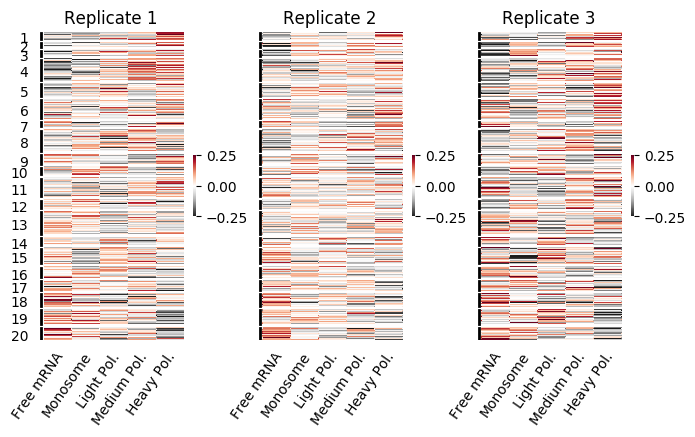

In [105]:
fig, ax = plt.subplots(1,3,figsize = (8,4),sharey = True, dpi=100,gridspec_kw={"wspace":0.2}) #, 'height_ratios': [1/vh, 1/vh, (vh+3)/vh]})

for j in [1,2,3]:
    df_whitespaceR = df_whitespace.iloc[:,:-1]
    df_whitespaceR.columns = ['count_%s_rep%s'%(s,j) for s in ['Free','Mono','LP','MP','HP']] +['cluster_id','cluster_id_total']
    df_clust = df_clust_total[j].append(df_whitespaceR)
    df_clust = df_clust.loc[df_clust_total[4].append(df_whitespace).sort_values('cluster_order2').index,:].reset_index(drop=True)
    sns.heatmap(df_clust.iloc[:,:5],cmap="RdGy_r", vmin=-0.25, vmax=0.25,ax=ax[j-1],rasterized = True,
               cbar_kws = {'shrink': 0.2,'ticks' : [-0.25, 0,0.25]},)


    hlines = [0]
    prev = 0
    idx = 0
    df_clust = df_clust_total[4].append(df_whitespace)
    for i in range(20):
        prev = idx
        idx = idx + len(df_clust[df_clust['cluster_order2']==i])+200
        ax[j-1].plot((-0.1,-0.1),(prev+100, idx-300), lw=2, c = 'black')
#     ax[j-1].hlines(idx, *ax[j-1].get_xlim(),lw = 2,colors='white')
        hlines = hlines + [(idx-(len(df_clust[df_clust['cluster_order2']==i])+200)/2)]


    ax[j-1].set_ylabel('')
    ax[j-1].set_title('Replicate %s'%j)
    
    ax[j-1].set_yticks(hlines[1:])
    ax[j-1].set_xlim(-0.2, 5)
    ax[j-1].set_yticklabels([str(i+1) for i in range(20)])
    ax[j-1].set_xticks([0.8+x for x in [0,1,2,3,4]])
    ax[j-1].xaxis.set_ticks_position('none')
    ax[j-1].yaxis.set_ticks_position('none') 
    ax[j-1].set_xticklabels(['Free mRNA','Monosome','Light Pol.','Medium Pol.','Heavy Pol.'],rotation=55,ha='right')
plt.tight_layout()

plt.savefig(savedir+'suppFigure2X_clusteringReps.pdf')


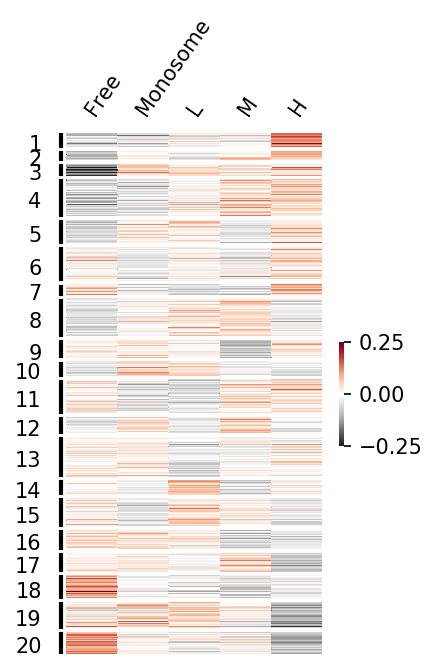

In [34]:
fig, ax = plt.subplots(1,1,figsize = (3,5.5*5/6),dpi=150) #,sharey = True, gridspec_kw={"wspace":0.2}) #, 'height_ratios': [1/vh, 1/vh, (vh+3)/vh]})

j=4
df_clust = df_clust_total[j].append(df_whitespace)
df_clust = df_clust.sort_values('cluster_order2').reset_index(drop=True)
sns.heatmap(df_clust.iloc[:,:5],cmap="RdGy_r", vmin=-0.25, vmax=0.25,ax=ax,rasterized = True,
           cbar_kws = {'shrink': 0.2,'ticks' : [-0.25, 0,0.25]}, )


hlines = [0]
prev = 0
idx = 0
for i in range(20):
    prev = idx
    idx = idx + len(df_clust[df_clust['cluster_order2']==i])+200
    ax.plot((-0.1,-0.1),(prev+100, idx-300), lw=2, c = 'black')
#     ax.hlines(idx, *ax.get_xlim(),lw = 2,colors='white')
    hlines = hlines + [(idx-(len(df_clust[df_clust['cluster_order2']==i])+200)/2)]

    
ax.set_yticks(hlines[1:])
ax.set_xlim(-0.2, 5)
ax.set_yticklabels([str(i+1) for i in range(20)])
ax.set_xticks([0.3+x for x in [0,1,2,3,4]])
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none') 
# ax.set_xlabel('X LABEL')    
# ax.xaxis.set_tlabel_position('top') 
ax.set_xticklabels(['Free','Monosome','L','M','H'],rotation=55,ha='left')
plt.tight_layout()
plt.savefig(savedir+'Figure2B_clustering-size2.pdf')

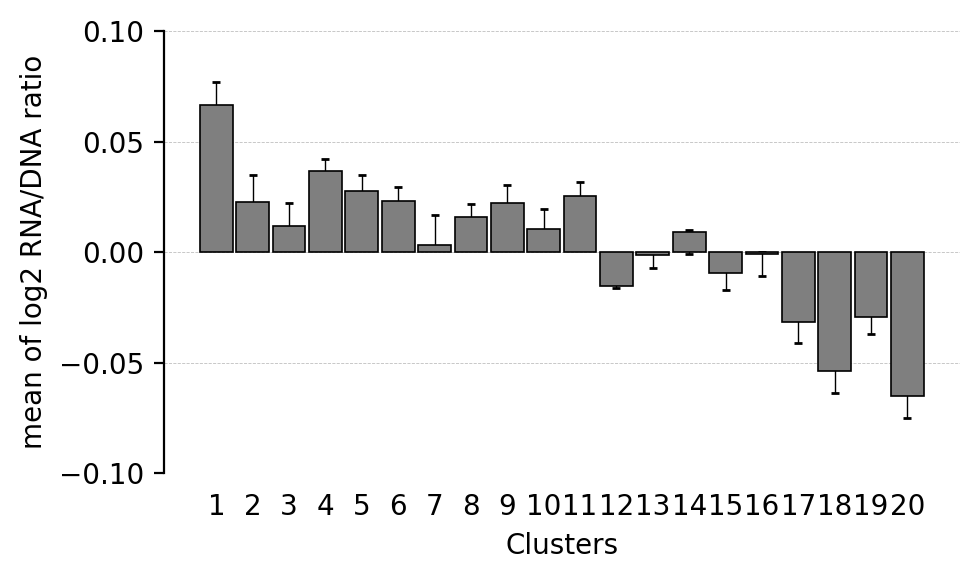

In [36]:
tmp_df = pd.merge(DEresultmean_stab,df_clust_total[4].reset_index(),on='species')
from scipy.stats import sem
tmp_df = tmp_df.groupby('cluster_order2').mean()

matplotlib.rc_file_defaults()
plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
fig, ax = plt.subplots(figsize=(5,3),dpi = 200)

plt.bar(tmp_df.index,tmp_df['logFC'],
        0.9, #width
        #alpha=0.5, 
        color= '#7F7F7F', #colors,    #'#EE3224', 
        edgecolor = 'black',
        linewidth=0.6,
        # with label the first value in first_name
        #label=df['first_name'][0],
        zorder = 3) 

yerr = pd.merge(DEresultmean_stab,df_clust_total[4].reset_index(),on='species')
yerr = yerr.groupby('cluster_order2').agg(lambda x: sem(x))['logFC']

plt.errorbar(tmp_df.index[:12], tmp_df['logFC'][:12], yerr=[np.zeros(len(yerr[:12]))+0.001,yerr[:12]],
             fmt='none',ecolor='black',elinewidth =0.5, capsize=1.5,zorder = 2)

plt.errorbar(tmp_df.index[12:], tmp_df['logFC'][12:], yerr=[yerr[12:],np.zeros(len(yerr[12:]))+0.001],
             fmt='none',ecolor='black',elinewidth =0.5, capsize=1.5,zorder = 2)

plt.xticks(range(20), [i+1 for i in range(20)])
plt.ylabel('mean of log2 RNA/DNA ratio')
plt.yticks([-0.1,-0.05, 0, 0.05, 0.1])
ax.yaxis.grid(True, color='gray',linestyle='--' , linewidth=0.3,alpha=0.5,zorder = -1)
# ax.xaxis.grid(True, color='gray',linestyle='--' , linewidth=0.3,alpha=0.5,zorder = 0)

ax.xaxis.set_ticks_position('none') 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.set_title('HCT116', size = 10)
ax.set_xlabel('Clusters')
ax.set_ylim(-0.1,0.1)
plt.tight_layout()
plt.rcParams['pdf.use14corefonts'] = True
plt.savefig(savedir + 'suppFigure2X(log2FCtrend,clusters).pdf')

In [37]:
print(df_clust_total[4][df_clust_total[4].index ==C1_sp])

tmp = df_clust_total[4].reset_index()
df_pos = tmp[tmp['species'].str.contains('SL27')][
    tmp['species'].str.contains('POSITIVE')][
    tmp['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])<=11)][tmp['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])>=8)] #3~12
df_pos

                                                    count_Free  count_Mono  \
species                                                                      
TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|812...   -0.237098   -0.072902   

                                                    count_LP  count_MP  \
species                                                                  
TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|812... -0.045637   0.09202   

                                                    count_HP  cluster_id  \
species                                                                    
TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|812...  0.263617          10   

                                                    cluster_order  \
species                                                             
TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|812...              0   

                                                    cluster_order2  
species                             

,species,count_Free,count_Mono,count_LP,count_MP,count_HP,cluster_id,cluster_order,cluster_order2
25339,TILE_ID_144-00008|POSITIVE_CONTROL(SL27)|GU937...,0.015038,-0.030676,-0.041662,-0.095241,0.152542,15,2,6
25340,TILE_ID_144-00009|POSITIVE_CONTROL(SL27)|GU937...,-0.107739,-0.050740,0.030594,-0.063585,0.191470,10,0,0
25341,TILE_ID_144-00010|POSITIVE_CONTROL(SL27)|GU937...,-0.153525,-0.062473,-0.015342,-0.035503,0.266843,10,0,0
25342,TILE_ID_144-00011|POSITIVE_CONTROL(SL27)|GU937...,-0.163808,-0.025666,-0.005052,-0.060037,0.254563,10,0,0


In [38]:
tmp = df_clust_total[4].reset_index()
df_neg = tmp[tmp['species'].str.contains('SL27')][
    tmp['species'].str.contains('NEGATIVE')][
    tmp['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])<=11)][tmp['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])>=8)] #3~12
df_neg

,species,count_Free,count_Mono,count_LP,count_MP,count_HP,cluster_id,cluster_order,cluster_order2
25372,TILE_ID_146-00008|NEGATIVE_CONTROL(SL27mut)|GU...,0.026564,0.021492,-0.046515,-0.068848,0.067306,15,2,6
25373,TILE_ID_146-00009|NEGATIVE_CONTROL(SL27mut)|GU...,0.019460,0.102924,0.035674,-0.129332,-0.028727,13,16,15
25374,TILE_ID_146-00010|NEGATIVE_CONTROL(SL27mut)|GU...,0.117072,0.033959,0.014080,-0.127084,-0.038027,9,11,17
25375,TILE_ID_146-00011|NEGATIVE_CONTROL(SL27mut)|GU...,0.068665,-0.035929,0.087692,-0.092303,-0.028125,1,15,14


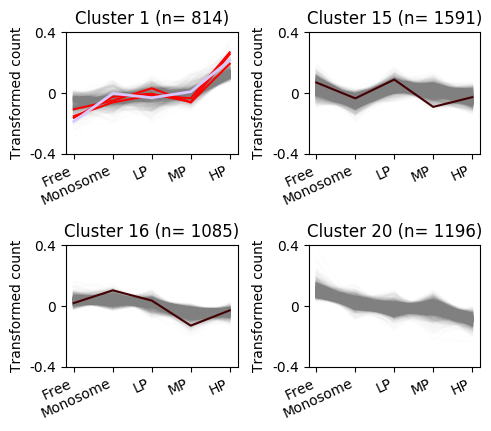

In [41]:
WPRE_sp = 'TILE_ID_032-00022|WOODCHUCK_HEPATITIS_VIRUS|NC_004107.1|1366,1495|PRETILE_ID_032-00001|PREPRETILE_ID_032-00001'
matplotlib.rc_file_defaults()
plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

fig = plt.figure(figsize=(5,6),dpi=100)
df_clust = df_clust_total[4]
for j,s in enumerate([0,14,15,19]):
    ax = fig.add_subplot(3,2,j+1)
    clust_temp = df_clust[df_clust['cluster_order2']==s].iloc[:3000,:-1]
    for i in range(len(clust_temp)):
        ax.plot(list(range(5)),clust_temp.iloc[i,:5],color='grey',alpha=0.01,zorder=-10)
    ##
    dfneg_tmp = df_neg[df_neg['cluster_order2']==s]
    for i in range(len(dfneg_tmp)):
        ax.plot(list(range(5)),dfneg_tmp.iloc[i,1:6],color='#440003',zorder = 3,lw=1.5)

    ##
    dfpos_tmp = df_pos[df_pos['cluster_order2']==s]
    for i in range(len(dfpos_tmp)):
        ax.plot(list(range(5)),dfpos_tmp.iloc[i,1:6],color='red',zorder = 3,lw=1.5)
    ##
    df_tmp = df_clust_total[4][df_clust_total[4].index ==WPRE_sp]
    df_tmp = df_tmp[df_tmp['cluster_order2']==s]
    for i in range(len(df_tmp)):
        ax.plot(list(range(5)),df_tmp.iloc[i,:5],color='#d8c7ff',zorder = 3,lw=2)   #d8c7ff
    ax.set_ylim(-0.4, 0.4)
    ax.set_yticks([-0.4, 0,0.4])
    ax.set_yticklabels([-0.4, 0, 0.4])
    ax.set_rasterization_zorder(0)
    ax.set_ylabel('Transformed count')
    ax.set_title('Cluster %s (n= %s)'%(s+1, len(clust_temp)))
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(['Free','Monosome','LP','MP','HP'],rotation=25, ha='right')

plt.tight_layout()
plt.savefig(savedir+'Figure2C_specificclusters2.pdf')


In [50]:
tmp_df = df_clust_total[4].copy()
tmp_df['HP/Free'] = tmp_df['count_HP']-  tmp_df['count_Free']
tmp_df = tmp_df.sort_values('HP/Free',ascending = False).reset_index()

#tmp_df[tmp_df['species'] == C1_sp]
[print('%s.'%(i+1),'\t'.join(x.split('|')[1:4])) for i,x in enumerate(tmp_df.head(n=25)['species'])]
tmp_df.head(n=25)

1. RUBELLA_VIRUS	NC_001545.2	6626,6755
2. RUBELLA_VIRUS	NC_001545.2	6691,6820
3. HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS_2)	NC_001798.2	126646,126775
4. YELLOW_FEVER_VIRUS_(YFV)	NC_002031.1	9011,9140
5. HUMAN_GAMMAHERPESVIRUS_8_(KAPOSI'S_SARCOMA-ASSOCIATED_HERPESVIRUS)	NC_009333.1	90911,90782
6. SAINT_LOUIS_ENCEPHALITIS_VIRUS	NC_007580.2	2492,2621
7. NY_014_POXVIRUS	NC_035469.1	125509,125380
8. GB_VIRUS_C_(GBV-HGV)	NC_001710.1	2633,2762
9. MIDDLE_EAST_RESPIRATORY_SYNDROME-RELATED_CORONAVIRUS_(MERS-COV)	NC_019843.3	13911,14040
10. HUMAN_BETAHERPESVIRUS_5_(HHV-5__HCMV)	NC_006273.2	4579,4450
11. MAMMALIAN_ORTHOREOVIRUS_3	NC_013233.1	66,195
12. HUMAN_BETAHERPESVIRUS_5_(HHV-5__HCMV)	NC_006273.2	49953,49824
13. MOLLUSCUM_CONTAGIOSUM_VIRUS_SUBTYPE_1	NC_001731.1	80070,80199
14. INFECTIOUS_SPLEEN_AND_KIDNEY_NECROSIS_VIRUS_(ISKNV)	NC_003494.1	12399,12528
15. DENGUE_VIRUS_1	NC_001477.1	10548,10677
16. AICHI_VIRUS_1	NC_001918.1	8122,8251
17. HUMAN_ASTROVIRUS	NC_001943.1	3938,4067
18. NOROVI

,species,count_Free,count_Mono,count_LP,count_MP,count_HP,cluster_id,cluster_order,cluster_order2,HP/Free
0,TILE_ID_085-00096|RUBELLA_VIRUS|NC_001545.2|66...,-0.889708,0.413262,0.223987,0.152215,0.100244,3,8,2,0.989952
1,TILE_ID_085-00097|RUBELLA_VIRUS|NC_001545.2|66...,-0.850295,0.396569,0.276034,0.086538,0.091154,3,8,2,0.941449
2,TILE_ID_136-00311|HUMAN_ALPHAHERPESVIRUS_2_(HE...,-0.845095,0.402204,0.266425,0.164659,0.011808,3,8,2,0.856903
3,TILE_ID_092-00138|YELLOW_FEVER_VIRUS_(YFV)|NC_...,-0.577825,0.110833,0.093139,0.218669,0.155186,3,8,2,0.733011
4,TILE_ID_132-00719|HUMAN_GAMMAHERPESVIRUS_8_(KA...,-0.461746,0.174145,0.087630,0.057084,0.142887,3,8,2,0.604633
5,TILE_ID_093-00039|SAINT_LOUIS_ENCEPHALITIS_VIR...,-0.440993,0.069791,0.097202,0.140463,0.133536,3,8,2,0.574529
6,TILE_ID_141-00766|NY_014_POXVIRUS|NC_035469.1|...,-0.216230,-0.041784,-0.057434,-0.008810,0.324257,10,0,0,0.540487
7,TILE_ID_080-00041|GB_VIRUS_C_(GBV-HGV)|NC_0017...,-0.399603,0.115031,0.103554,0.041705,0.139313,3,8,2,0.538915
8,TILE_ID_127-00215|MIDDLE_EAST_RESPIRATORY_SYND...,-0.291813,-0.038253,0.006760,0.079804,0.243503,10,0,0,0.535316
9,TILE_ID_143-00440|HUMAN_BETAHERPESVIRUS_5_(HHV...,-0.192322,-0.128008,-0.083636,0.065831,0.338135,10,0,0,0.530457


In [52]:
idx_filter = df_vst[df_vst['count_mean']>6]['species']

0.06729279626742593
44


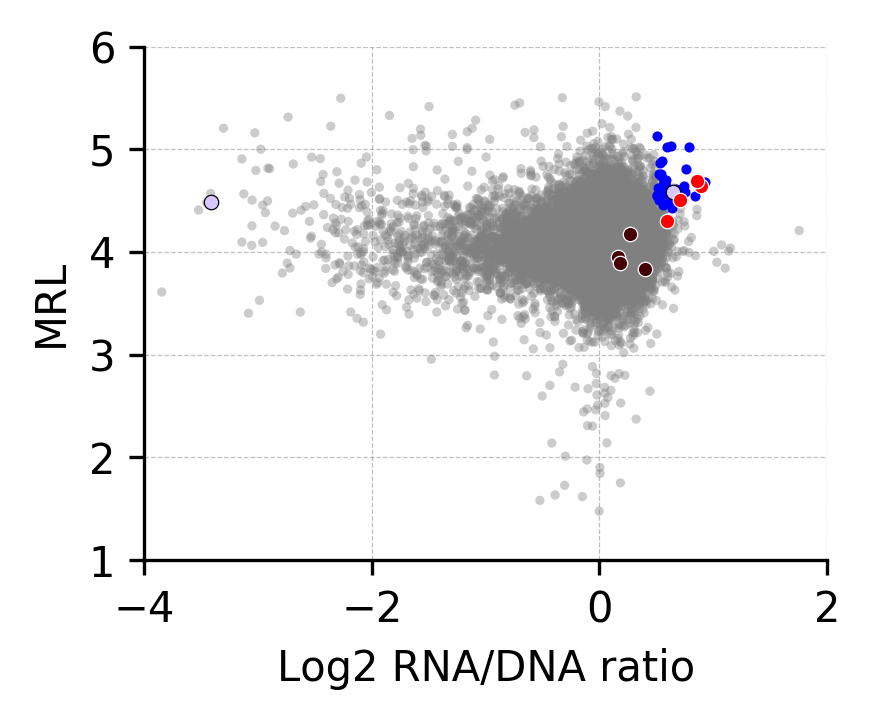

In [115]:
tmp = df_vst.copy() 
tmp = tmp[tmp['count_mean']>6]
sps = tmp['species']

matplotlib.rc_file_defaults()
plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

size = 5;alpha=0.4
HCMV_sp = 'TILE_ID_143-00440|HUMAN_BETAHERPESVIRUS_5_(HHV-5__HCMV)|NC_006273.2|4579,4450|PRETILE_ID_143-00084|PREPRETILE_ID_143-00071'
HDV_sp = 'TILE_ID_016-00011|HEPATITIS_DELTA_VIRUS|NC_001653.2|651,780|PRETILE_ID_016-00001|PREPRETILE_ID_016-00001'
WPRE_sp = 'TILE_ID_032-00022|WOODCHUCK_HEPATITIS_VIRUS|NC_004107.1|1366,1495|PRETILE_ID_032-00001|PREPRETILE_ID_032-00001'

with open('/casa/jenny/notebooks/pan-viral_MPRA/pickles/DEsumresult_stab.pickle', 'rb') as f:
    DEresultmean_stab = pickle.load(f)
DEresultmean_stab.columns = ['species']+list(DEresultmean_stab.columns[1:])


fig, ax = plt.subplots(1,1,figsize=(3,2.5),dpi = 300)


tmp_df = pd.merge(DEresultmean_stab,df_fraction,on='species')
tmp_df = tmp_df[tmp_df['species'].isin(sps)]


ax.scatter(tmp_df['logFC'],tmp_df['MRL'],color='grey',s=size, alpha = alpha,edgecolors='none',rasterized =True,zorder = 2)

tmp = tmp_df[tmp_df['species'].isin(set(idx_list))]
ax.scatter(tmp['logFC'],tmp['MRL'],color='blue',s=2, label = 'Candidates',zorder = 2)

tmp = tmp_df[tmp_df['species'].isin([HDV_sp])]
ax.scatter(tmp['logFC'],tmp['MRL'],color='#d8c7ff',s=12,
          edgecolor = 'black',linewidth= 0.3,zorder = 2)

tmp = tmp_df[tmp_df['species'].isin([WPRE_sp])]
ax.scatter(tmp['logFC'],tmp['MRL'],color='#d8c7ff',s=12,
          edgecolor = 'black',linewidth= 0.3,zorder = 2)

# tmp = tmp_df[tmp_df['species'].isin([C1_sp,HCMV_sp])]
# ax.scatter(tmp['logFC'],tmp['MRL'],color='#d8c7ff',s=12,
#           edgecolor = 'black',linewidth= 0.3, label = 'Candidates 2')
print(scipy.stats.spearmanr(tmp_df['MRL'],tmp_df['logFC'])[0])
tmp = tmp_df[tmp_df['species'].isin(SL27_pos_sp['species'])]
ax.scatter(tmp['logFC'],tmp['MRL'],color='red',s=12,
          edgecolor = 'white',linewidth= 0.3, label = '1E',zorder = 2)
tmp = tmp_df[tmp_df['species'].isin(SL27_neg_sp['species'])]
ax.scatter(tmp['logFC'],tmp['MRL'],color='#440003',s=12,
          edgecolor = 'white',linewidth= 0.3, label = '1E SLmut',zorder = 2)
ax.set_xlabel('Log2 RNA/DNA ratio')
ax.set_ylabel('MRL')

ax.yaxis.grid(True, color='gray',linestyle='--' , linewidth=0.3,alpha=0.5,zorder = 0)
ax.xaxis.grid(True, color='gray',linestyle='--' , linewidth=0.3,alpha=0.5,zorder = 0)


ax.set_ylim(1,6)
ax.set_xlim(-4, 2)

# ax.set_title('RNA abundance vs Translation')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.legend(loc=3,prop={'size': 6})
print(len(idx_list))
plt.tight_layout()
plt.savefig(savedir +'suppFigure2X(MRLvsStab).pdf')

0.07270104923131804
44


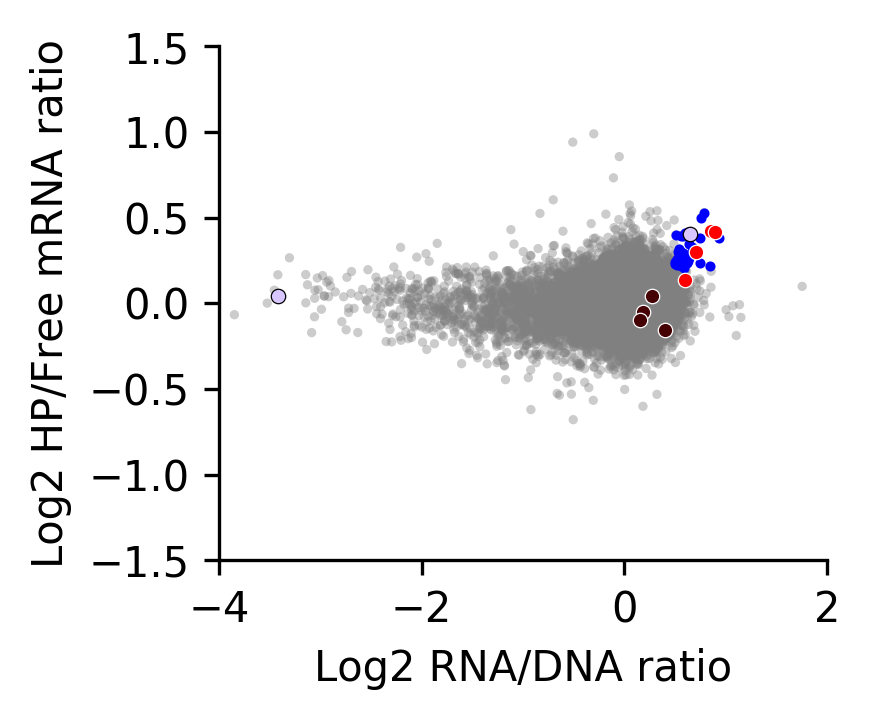

In [114]:
tmp_df = df_vst.copy()
tmp_df['MRL'] = tmp_df['count_HP']-  tmp_df['count_Free']
tmp_df = tmp_df.reset_index()
matplotlib.rc_file_defaults()
plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

with open('/casa/jenny/notebooks/pan-viral_MPRA/pickles/DEsumresult_stab.pickle', 'rb') as f:
    DEresultmean_stab = pickle.load(f)
DEresultmean_stab.columns = ['species']+list(DEresultmean_stab.columns[1:])
  
size = 5;alpha=0.4
HCMV_sp = 'TILE_ID_143-00440|HUMAN_BETAHERPESVIRUS_5_(HHV-5__HCMV)|NC_006273.2|4579,4450|PRETILE_ID_143-00084|PREPRETILE_ID_143-00071'
HDV_sp = 'TILE_ID_016-00011|HEPATITIS_DELTA_VIRUS|NC_001653.2|651,780|PRETILE_ID_016-00001|PREPRETILE_ID_016-00001'
WPRE_sp = 'TILE_ID_032-00022|WOODCHUCK_HEPATITIS_VIRUS|NC_004107.1|1366,1495|PRETILE_ID_032-00001|PREPRETILE_ID_032-00001'


fig, ax = plt.subplots(1,1,figsize=(3,2.5),dpi = 300)


tmp_df = pd.merge(tmp_df,DEresultmean_stab,on='species')
tmp_df = tmp_df[tmp_df['species'].isin(sps)]

ax.scatter(tmp_df['logFC'],tmp_df['MRL'],color='grey',s=size, alpha = alpha,edgecolors='none',rasterized =True)
print(scipy.stats.spearmanr(tmp_df['MRL'],tmp_df['logFC'])[0])

tmp = tmp_df[tmp_df['species'].isin(set(idx_list))]
ax.scatter(tmp['logFC'],tmp['MRL'],color='blue',s=2, label = 'Candidates')

tmp = tmp_df[tmp_df['species'].isin([HDV_sp])]
ax.scatter(tmp['logFC'],tmp['MRL'],color='#d8c7ff',s=12,
          edgecolor = 'black',linewidth= 0.3)

# tmp = tmp_df[tmp_df['species'].isin([C1_sp])]
# ax.scatter(tmp['logFC'],tmp['MRL'],color='green',s=12,
#           edgecolor = 'black',linewidth= 0.3, label = 'K5')

tmp = tmp_df[tmp_df['species'].isin([WPRE_sp])]
ax.scatter(tmp['logFC'],tmp['MRL'],color='#d8c7ff',s=12,
          edgecolor = 'black',linewidth= 0.3, label = 'WPRE')

# tmp = tmp_df[tmp_df['species'].isin([C1_sp,HCMV_sp])]
# ax.scatter(tmp['logFC'],tmp['MRL'],color='#d8c7ff',s=12,
#           edgecolor = 'black',linewidth= 0.3, label = 'Candidates 2')

tmp = tmp_df[tmp_df['species'].isin(SL27_pos_sp['species'])]
ax.scatter(tmp['logFC'],tmp['MRL'],color='red',s=12,
          edgecolor = 'white',linewidth= 0.3, label = '1E')
tmp = tmp_df[tmp_df['species'].isin(SL27_neg_sp['species'])]
ax.scatter(tmp['logFC'],tmp['MRL'],color='#440003',s=12,
          edgecolor = 'white',linewidth= 0.3, label = '1E SLmut')
ax.set_xlabel('Log2 RNA/DNA ratio')
ax.set_ylabel('Log2 HP/Free mRNA ratio')


ax.set_ylim(-1.5,1.5)
ax.set_xlim(-4,2)
print(len(idx_list))
# ax.set_title('RNA abundance vs Translation')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.legend(loc=3,prop={'size': 6})

plt.tight_layout()
plt.savefig(savedir +'Figure2X(HPFreevsStab).pdf')

In [66]:
import scipy
tmp_df = pd.merge(DEresultmean_stab,df_fraction,on='species')
scipy.stats.spearmanr(tmp_df['MRL'],tmp_df['logFC'])[0]

0.06928878390110917

In [67]:
tmp_df = df_vst.copy()
tmp_df['HP/Free'] = tmp_df['count_HP']-  tmp_df['count_Free']


##positive##
tmp_list = df_fraction[df_fraction['MRL']>4.5]['species']
print(len(tmp_df[tmp_df['HP/Free']>0.2][tmp_df['count_mean']>8][tmp_df['species'].isin(tmp_list)]))


##negative ###
tmp_list = df_fraction[df_fraction['MRL']<3.5]['species'] ; #print(len(tmp_list))
print(len(tmp_df[tmp_df['HP/Free']<-0.2][tmp_df['count_mean']>8][tmp_df['species'].isin(tmp_list)]))


535
66


In [77]:
idx_list_pt = [x for x in idx_list_pt if ('POSITIVE_CONTROL' not in x) and ('HCMV' not in x)]
print(len(idx_list_pt ))

36


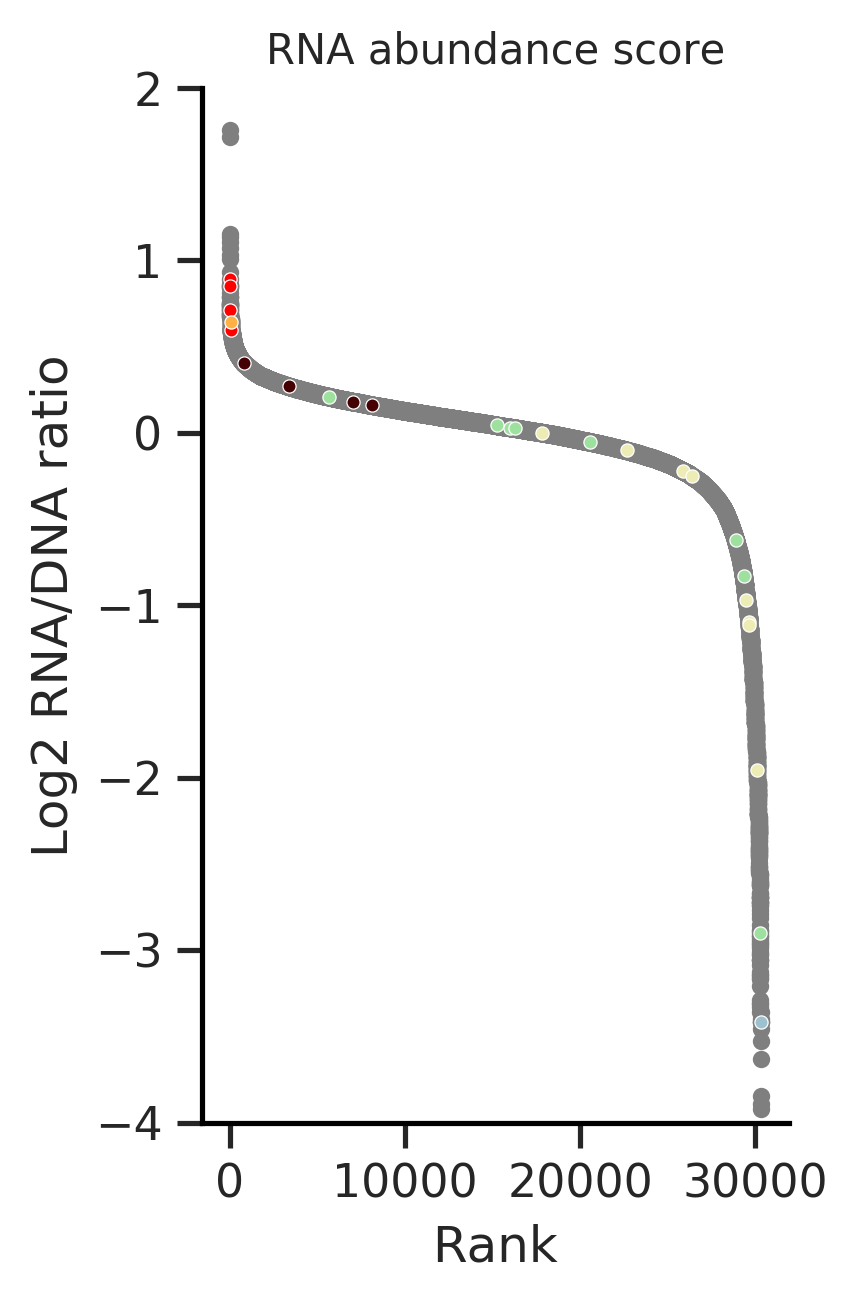

In [135]:
tmp_df = DEresultmean_stab.sort_values('logFC',ascending = False).reset_index(drop=True)
HDV = 'TILE_ID_016-00011|HEPATITIS_DELTA_VIRUS|NC_001653.2|651,780|PRETILE_ID_016-00001|PREPRETILE_ID_016-00001'
WPRE = 'TILE_ID_032-00022|WOODCHUCK_HEPATITIS_VIRUS|NC_004107.1|1366,1495|PRETILE_ID_032-00001|PREPRETILE_ID_032-00001'

with open('/casa/jenny/notebooks/pan-viral_MPRA/Data/220828_miRNAdf_filterall_10dist.pickle', 'rb') as f:
    miRNA_df = pickle.load(f)
miRNA = list(set(miRNA_df['seq_id'].apply(lambda x: x[:-10])))

miRNA_ebv = [x for x in miRNA if 'EPSTEIN-BARR_VIRUS' in x]
miRNA_cmv = [x for x in miRNA if '5__HCMV' in x]

tmp_pos = tmp_df[tmp_df['species'].isin(SL27_pos_sp['species'])]
tmp_neg = tmp_df[tmp_df['species'].isin(SL27_neg_sp['species'])]

plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none'

pos = list(range(len(tmp_df))) 
width = 0.35

# Plotting the bars
fig, ax = plt.subplots(figsize=(3,5*0.9),dpi = 300)

# Create a bar with pre_score data,
# in position pos,
plt.scatter([width*p for p in pos],
         [p for p in tmp_df['logFC']],
        #alpha=0.5, 
        color= '#7F7F7F', #colors,    #'#EE3224', 
        marker = 'o',s = 10,
#         edgecolor = 'white',linewidth= 0.05,
        zorder = 3,rasterized = True) 

color = [(0.7534313725490196, 0.23872549019607847, 0.24166666666666664, 1)] *6 +[
    (0.8818627450980391, 0.5053921568627451, 0.17303921568627467, 1)] *5 + [
    (236/264, 236/264, 180/264, 1)] *3 + [
    (0.5784313725490194, 0.446078431372549, 0.6990196078431372, 1)] *10 +[
    (0, 181/264, 226/264, 1)] *12 +[
    (0.19460784313725488, 0.45343137254901944, 0.632843137254902, 1)] *1 + [
    (0.22941176470588232, 0.5705882352941177, 0.22941176470588232, 1) ] *1

plt.scatter([width*p for p in tmp_pos.index],
         [p for p in tmp_pos['logFC']],
        #alpha=0.5, 
        color= 'red', #colors,    #'#EE3224', 
        marker = 'o',s = 10,
        edgecolor = 'white',linewidth= 0.3,
        zorder = 3) 

plt.scatter([width*p for p in tmp_neg.index],
         [p for p in tmp_neg['logFC']],
        #alpha=0.5, 
        color= '#440003', #colors,    #'#EE3224', 
        marker = 'o',s = 10,
        edgecolor = 'white',linewidth= 0.3,
        zorder = 3) 

tmp_neg = tmp_df[tmp_df['species'].isin([HDV])]
plt.scatter([width*p for p in tmp_neg.index],
         [p for p in tmp_neg['logFC']],
        #alpha=0.5, 
        color= '#9EC1CF',#'#d8c7ff', #colors,    #'#EE3224', 
#         edgecolor = 'black',
        marker = 'o',s = 10,
        edgecolor = 'white',linewidth= 0.3,
#          label = 'IH element',
        zorder = 3,rasterized = True) 

tmp_neg = tmp_df[tmp_df['species'].isin([WPRE])]
plt.scatter([width*p for p in tmp_neg.index],
         [p for p in tmp_neg['logFC']],
        #alpha=0.5, 
        color= '#FEB144', #colors,    #'#EE3224', 
#         edgecolor = 'black',
        marker = 'o',s = 10,
        edgecolor = 'white',linewidth= 0.3,
#          label = 'IH element',
        zorder = 3,rasterized = True) 


tmp_neg = tmp_df[tmp_df['species'].isin(miRNA_ebv)]
plt.scatter([width*p for p in tmp_neg.index],
         [p for p in tmp_neg['logFC']],
        #alpha=0.5, 
        color= '#ececb4',#'#FDFD97',#'#d8c7ff', #colors,    #'#EE3224', 
#         edgecolor = 'black',
        marker = 'o',s = 10,
        edgecolor = 'white',linewidth= 0.3,
#          label = 'IH element',
        zorder = 3,rasterized = True) 

tmp_neg = tmp_df[tmp_df['species'].isin(miRNA_cmv)]
plt.scatter([width*p for p in tmp_neg.index],
         [p for p in tmp_neg['logFC']],
        #alpha=0.5, 
        color= '#9EE09E',#'#d8c7ff', #colors,    #'#EE3224', 
#         edgecolor = 'black',
        marker = 'o',s = 10,
        edgecolor = 'white',linewidth= 0.3,
#          label = 'IH element',
        zorder = 3,rasterized = True) 
ax.set_ylabel('Log2 RNA/DNA ratio')

# Set the position of the x ticks
ax.set_xticks([0,width*10000, width*20000, width*30000])

# Set the labels for the x ticks
ax.set_xticklabels([0,10000,20000,30000])

#plt.ylim([0, max(df['pre_score'] + df['mid_score'])] )
plt.ylim(-4,2)
ax.set_yticks([-4,-3,-2,-1,0,1,2])

# plt.grid(False)

# ax.xaxis.set_ticks_position('none') 
#plt.axis('off')
ax.set_axisbelow(True)
# ax.yaxis.grid(True, color='gray',linestyle='-' , linewidth=0.3,alpha=0.7,zorder = 0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.set_title('RNA abundance score', size = 10)
ax.set_xlabel('Rank')
plt.tight_layout()
# plt.legend()
plt.rcParams['pdf.use14corefonts'] = True
plt.savefig(savedir +'Figure2A(RNAstab).pdf')
plt.show()

# Baltimore

In [80]:
with open('/casa/jenny/notebooks/pan-viral_MPRA/pickles/DEsumresult_stab.pickle', 'rb') as f:
    DEresultmean_stab = pickle.load(f)
DEresultmean_stab.columns = ['species']+list(DEresultmean_stab.columns[1:])

with open('/casa/jenny/notebooks/pan-viral_MPRA/Data/df_tax144.pickle', 'rb') as f:
    df_tax = pickle.load(f)
df_tax.head()

,Genome Type,FAMILY,GENUS,Name,Segment,ID
0,DS-DNA,ADENOVIRIDAE,MASTADENOVIRUS,HUMAN MASTADENOVIRUS A,GENOME,NC_001460.1
1,DS-DNA,HERPESVIRIDAE,CYTOMEGALOVIRUS,HUMAN BETAHERPESVIRUS 5 (HHV-5; HCMV),GENOME,NC_006273.2
2,DS-DNA,HERPESVIRIDAE,LYMPHOCRYPTOVIRUS,HUMAN GAMMAHERPESVIRUS 4 (EPSTEIN-BARR VIRUS),GENOME,NC_007605.1
3,DS-DNA,HERPESVIRIDAE,RHADINOVIRUS,HUMAN GAMMAHERPESVIRUS 8 (KAPOSI'S SARCOMA-ASS...,GENOME,NC_009333.1
4,DS-DNA,HERPESVIRIDAE,ROSEOLOVIRUS,HUMAN BETAHERPESVIRUS 6B (HHV-6B),GENOME,NC_000898.1


In [81]:
df_balt = df_clust_total[4].reset_index()
df_balt['ID'] = df_balt['species'].apply(lambda x: x.split('|')[2])
df_balt = pd.merge(df_balt, df_tax, on='ID', how='left')
df_balt = df_balt.groupby(['cluster_order2','Genome Type']).count()['ID'].reset_index()

for i in range(15):
    df_tmp = df_balt[df_balt['cluster_order2']==i]
    a, b = df_tmp['Genome Type'], df_tmp['ID']
    print('cluster',i+1)
    [print(a1,b1, end=',') for a1,b1 in zip(a,b)]
    print()

cluster 1
DS-DNA 197,DS-RNA 28,RT-DNA 3,RT-RNA 35,SS-DNA 5,SS-NEG-RNA 222,SS-POS-RNA 313,
cluster 2
DS-DNA 128,DS-RNA 15,RT-DNA 1,RT-RNA 25,SS-DNA 3,SS-NEG-RNA 159,SS-POS-RNA 196,
cluster 3
DS-DNA 218,DS-RNA 30,RT-DNA 2,RT-RNA 26,SS-DNA 4,SS-NEG-RNA 149,SS-POS-RNA 221,
cluster 4
DS-DNA 539,DS-RNA 98,RT-DNA 8,RT-RNA 94,SS-DNA 11,SS-NEG-RNA 519,SS-POS-RNA 821,
cluster 5
DS-DNA 347,DS-RNA 46,RT-DNA 7,RT-RNA 56,SS-DNA 8,SS-NEG-RNA 368,SS-POS-RNA 482,
cluster 6
DS-DNA 466,DS-RNA 70,RT-DNA 11,RT-RNA 90,SS-DNA 14,SS-NEG-RNA 548,SS-POS-RNA 686,
cluster 7
DS-DNA 147,DS-RNA 22,RT-DNA 1,RT-RNA 27,SS-DNA 4,SS-NEG-RNA 188,SS-POS-RNA 201,
cluster 8
DS-DNA 612,DS-RNA 98,RT-DNA 8,RT-RNA 76,SS-DNA 13,SS-NEG-RNA 493,SS-POS-RNA 820,
cluster 9
DS-DNA 282,DS-RNA 37,RT-DNA 3,RT-RNA 49,SS-DNA 13,SS-NEG-RNA 234,SS-POS-RNA 388,
cluster 10
DS-DNA 260,DS-RNA 43,RT-DNA 4,RT-RNA 35,SS-DNA 5,SS-NEG-RNA 202,SS-POS-RNA 259,
cluster 11
DS-DNA 469,DS-RNA 82,RT-DNA 6,RT-RNA 94,SS-DNA 9,SS-NEG-RNA 484,SS-POS-RNA 748,
clu

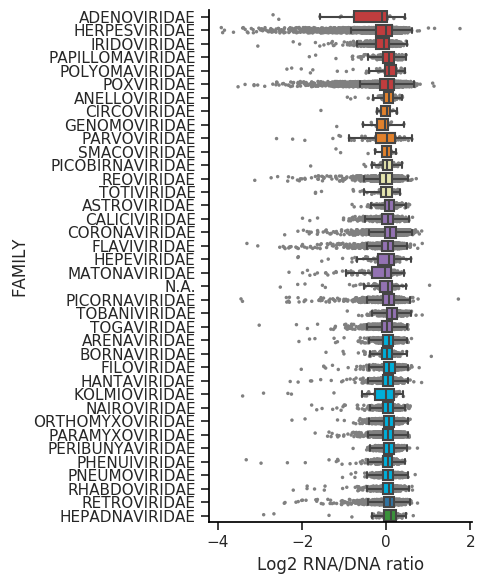

In [293]:
sns.set(rc={'figure.figsize':(5,6),"figure.dpi":100, 'savefig.dpi':300,'axes.facecolor':'white','axes.spines.left': True,
        'axes.spines.bottom': True, 'axes.edgecolor': 'black','ytick.left': True,'xtick.bottom': True, 'font.family': ['Helvetica']}) 

teams = ['DS-DNA', 'SS-DNA','DS-RNA', 'SS-POS-RNA','SS-NEG-RNA','RT-RNA','RT-DNA']
df_balt = DEresultmean_stab
df_balt['ID'] = df_balt['species'].apply(lambda x: x.split('|')[2])
df_balt = pd.merge(df_balt, df_tax, on='ID', how='left')

df_balt = df_balt.sort_values('FAMILY').set_index('Genome Type').loc[teams,:].reset_index()

ax = sns.stripplot(x='logFC', y='FAMILY', data=df_balt, color="grey", jitter=0.2, size=2.5, zorder = 0,rasterized = True)
ax = sns.boxplot(x='logFC', y='FAMILY', data=df_balt, showfliers = False)

color = [(0.7534313725490196, 0.23872549019607847, 0.24166666666666664, 1)] *6 +[
    (0.8818627450980391, 0.5053921568627451, 0.17303921568627467, 1)] *5 + [
    (236/264, 236/264, 180/264, 1)] *3 + [
    (0.5784313725490194, 0.446078431372549, 0.6990196078431372, 1)] *10 +[
    (0, 181/264, 226/264, 1)] *12 +[
    (0.19460784313725488, 0.45343137254901944, 0.632843137254902, 1)] *1 + [
    (0.22941176470588232, 0.5705882352941177, 0.22941176470588232, 1) ] *1

for i,patch in enumerate(ax.artists):
    patch.set_facecolor(color[i])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(False)
ax.set_xlabel('Log2 RNA/DNA ratio')
    
plt.rcParams['pdf.use14corefonts'] = True
plt.tight_layout()
plt.savefig(savedir + 'Figure2(Family,RNAlog2FC).pdf')

plt.show()


In [84]:
plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

savedir = '/casa/jenny/notebooks/pan-viral_MPRA/paper_figures/'

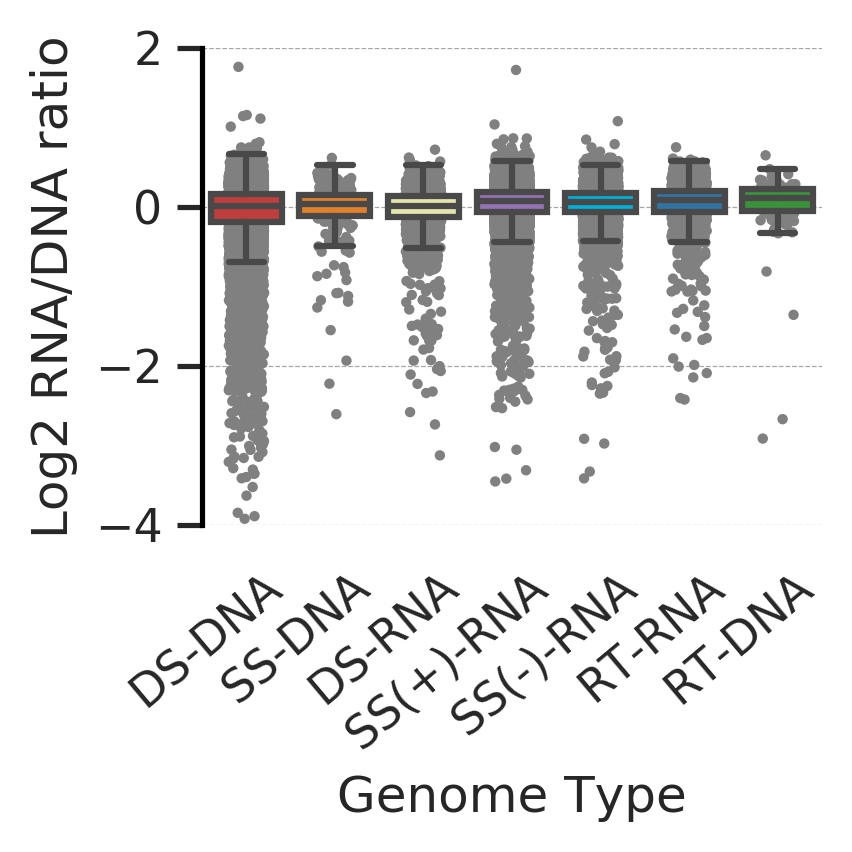

In [289]:
sns.set(rc={'figure.figsize':(3,3),"figure.dpi":300, 'savefig.dpi':300,'axes.facecolor':'white','axes.spines.left': True,
        'axes.spines.bottom': True, 'axes.edgecolor': 'black','ytick.left': True,'xtick.bottom': True, 'font.family': ['Helvetica']}) 

teams = ['DS-DNA', 'SS-DNA','DS-RNA', 'SS-POS-RNA','SS-NEG-RNA','RT-RNA','RT-DNA']
df_balt = df_balt.set_index('Genome Type').loc[teams,:].reset_index()

ax = sns.stripplot(x='Genome Type', y='logFC', data=df_balt, color="grey", jitter=0.2, size=2.5, zorder = 0,rasterized = True)
ax = sns.boxplot(x='Genome Type', y='logFC', data=df_balt, showfliers = False)
ax.set_xticks([p+0.5 for p in range(len(teams))])
ax.set_xticklabels(['DS-DNA', 'SS-DNA','DS-RNA', 'SS(+)-RNA','SS(-)-RNA','RT-RNA','RT-DNA'],rotation =40,ha='right')
ax.set_ylabel('Log2 RNA/DNA ratio')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks_position('none') 
ax.set_ylim(-4,2)

ax.yaxis.grid(True, color='gray',linestyle='--' , linewidth=0.3,alpha=0.7,zorder = 0)
# ax.xaxis.grid(True, color='white',linestyle='-' , linewidth=1,alpha=1,zorder = 1)
# for patch in ax.artists:
#     print(patch.get_facecolor())
color = [(0.7534313725490196, 0.23872549019607847, 0.24166666666666664, 1), 
         (0.8818627450980391, 0.5053921568627451, 0.17303921568627467, 1),
         (236/264, 236/264, 180/264, 1),
         (0.5784313725490194, 0.446078431372549, 0.6990196078431372, 1),
         (0, 181/264, 226/264, 1),
         (0.19460784313725488, 0.45343137254901944, 0.632843137254902, 1), 
         (0.22941176470588232, 0.5705882352941177, 0.22941176470588232, 1) 
        ]

for i,patch in enumerate(ax.artists):
    patch.set_facecolor(color[i])
    
plt.rcParams['pdf.use14corefonts'] = True
plt.tight_layout()
plt.savefig(savedir + 'Figure2(Balt,RNAlog2FC,ver).pdf')


plt.show()

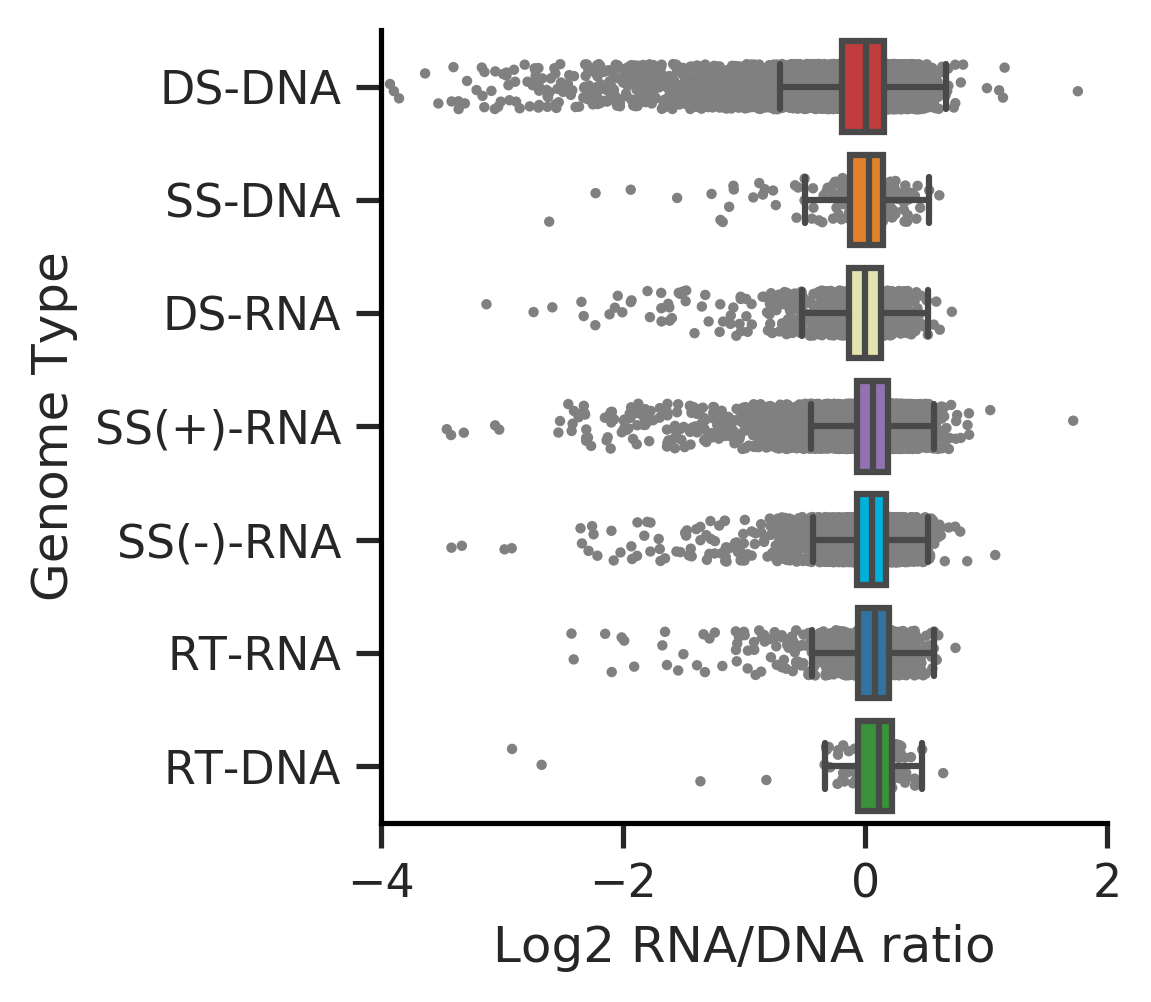

In [86]:
sns.set(rc={'figure.figsize':(4,3.5),"figure.dpi":300, 'savefig.dpi':300,'axes.facecolor':'white','axes.spines.left': True,
        'axes.spines.bottom': True, 'axes.edgecolor': 'black','ytick.left': True,'xtick.bottom': True, 'font.family': ['Helvetica']}) 

teams = ['DS-DNA', 'SS-DNA','DS-RNA', 'SS-POS-RNA','SS-NEG-RNA','RT-RNA','RT-DNA']
df_balt = df_balt.set_index('Genome Type').loc[teams,:].reset_index()

ax = sns.stripplot(y='Genome Type', x='logFC', data=df_balt, color="grey", jitter=0.2, size=2.5, zorder = 0)
ax = sns.boxplot(y='Genome Type', x='logFC', data=df_balt, showfliers = False)

ax.set_yticklabels(['DS-DNA', 'SS-DNA','DS-RNA', 'SS(+)-RNA','SS(-)-RNA','RT-RNA','RT-DNA'],rotation =0)
ax.set_xlabel('Log2 RNA/DNA ratio')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.xaxis.set_ticks_position('none') 
ax.set_xlim(-4,2)
ax.grid(False)

# for patch in ax.artists:
#     print(patch.get_facecolor())
color = [(0.7534313725490196, 0.23872549019607847, 0.24166666666666664, 1), 
         (0.8818627450980391, 0.5053921568627451, 0.17303921568627467, 1),
         (236/264, 236/264, 180/264, 1),
         (0.5784313725490194, 0.446078431372549, 0.6990196078431372, 1),
         (0, 181/264, 226/264, 1),
         (0.19460784313725488, 0.45343137254901944, 0.632843137254902, 1), 
         (0.22941176470588232, 0.5705882352941177, 0.22941176470588232, 1) 
        ]

for i,patch in enumerate(ax.artists):
    patch.set_facecolor(color[i])
    
plt.rcParams['pdf.use14corefonts'] = True
plt.tight_layout()
plt.savefig(savedir + 'Figure2(Balt,RNAlog2FC).pdf')

plt.show()

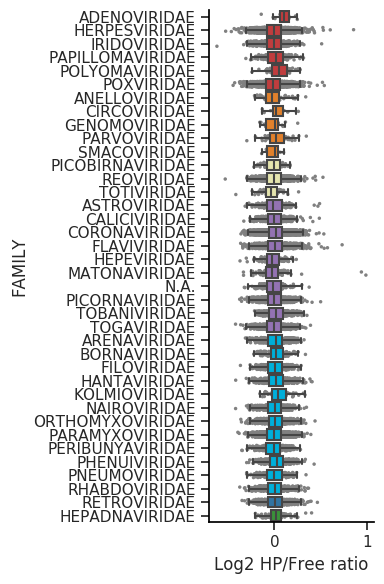

In [292]:
tmp = df_clust_total[4].copy()
tmp = tmp.reset_index()
tmp['logFC'] = tmp['count_HP']- tmp['count_Free']

sns.set(rc={'figure.figsize':(4,6),"figure.dpi":100, 'savefig.dpi':300,'axes.facecolor':'white','axes.spines.left': True,
        'axes.spines.bottom': True, 'axes.edgecolor': 'black','ytick.left': True,'xtick.bottom': True, 'font.family': ['Helvetica']}) 

tmp['ID'] = tmp['species'].apply(lambda x: x.split('|')[2])
tmp = pd.merge(tmp, df_tax, on='ID', how='left')
tmp = tmp.sort_values('FAMILY').set_index('Genome Type').loc[teams,:].reset_index()

ax = sns.stripplot(x='logFC', y='FAMILY', data=tmp, color="grey", jitter=0.2, size=2.5, zorder = 0,rasterized =True)
ax = sns.boxplot(x='logFC', y='FAMILY', data=tmp, showfliers = False)

color = [(0.7534313725490196, 0.23872549019607847, 0.24166666666666664, 1)] *6 +[
    (0.8818627450980391, 0.5053921568627451, 0.17303921568627467, 1)] *5 + [
    (236/264, 236/264, 180/264, 1)] *3 + [
    (0.5784313725490194, 0.446078431372549, 0.6990196078431372, 1)] *10 +[
    (0, 181/264, 226/264, 1)] *12 +[
    (0.19460784313725488, 0.45343137254901944, 0.632843137254902, 1)] *1 + [
    (0.22941176470588232, 0.5705882352941177, 0.22941176470588232, 1) ] *1

for i,patch in enumerate(ax.artists):
    patch.set_facecolor(color[i])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(False)
ax.set_xlabel('Log2 HP/Free ratio')
    
plt.rcParams['pdf.use14corefonts'] = True
plt.tight_layout()
plt.savefig(savedir + 'Figure2(FAMILY,translation).pdf')

plt.show()

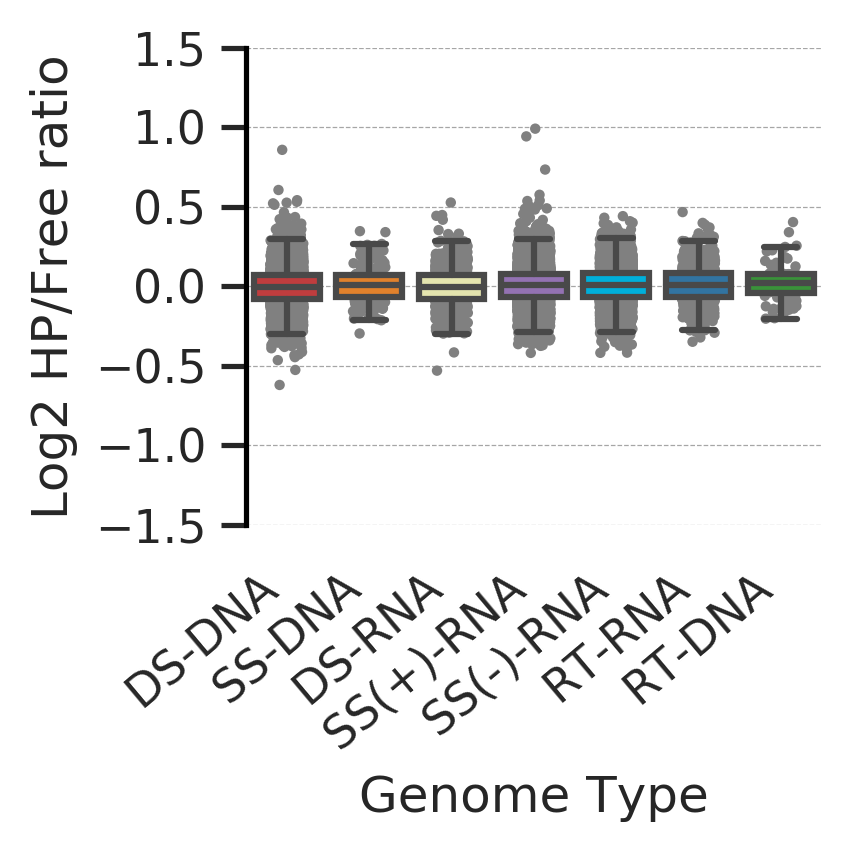

In [291]:
tmp = df_clust_total[4].copy()
tmp = tmp.reset_index()
tmp['HP/Free'] = tmp['count_HP']- tmp['count_Free']

sns.set(rc={'figure.figsize':(3,3),"figure.dpi":300, 'savefig.dpi':300,'axes.facecolor':'white','axes.spines.left': True,
        'axes.spines.bottom': True, 'axes.edgecolor': 'black','ytick.left': True,'xtick.bottom': True, 'font.family': ['Helvetica']}) 

tmp['ID'] = tmp['species'].apply(lambda x: x.split('|')[2])
tmp = pd.merge(tmp, df_tax, on='ID', how='left')


tmp = tmp.set_index('Genome Type').loc[teams,:].reset_index()

ax = sns.stripplot(x='Genome Type', y='HP/Free', data=tmp, color="grey", jitter=0.2, size=2.5, zorder = 0,rasterized = True)
ax = sns.boxplot(x='Genome Type', y='HP/Free', data=tmp, showfliers = False)

ax.set_xticklabels(['DS-DNA', 'SS-DNA','DS-RNA', 'SS(+)-RNA','SS(-)-RNA','RT-RNA','RT-DNA'],rotation =40,ha='right')
ax.set_ylabel('Log2 HP/Free ratio')

#     print(patch.get_facecolor())
color = [(0.7534313725490196, 0.23872549019607847, 0.24166666666666664, 1), 
         (0.8818627450980391, 0.5053921568627451, 0.17303921568627467, 1),
         (236/264, 236/264, 180/264, 1),
         (0.5784313725490194, 0.446078431372549, 0.6990196078431372, 1),
         (0, 181/264, 226/264, 1),
         (0.19460784313725488, 0.45343137254901944, 0.632843137254902, 1), 
         (0.22941176470588232, 0.5705882352941177, 0.22941176470588232, 1) 
        ]

for i,patch in enumerate(ax.artists):
    patch.set_facecolor(color[i])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks_position('none') 
ax.set_ylim(-1.5,1.5)
ax.set_yticks([-1.5, -1, -0.5, 0,0.5,1, 1.5])
#ax.grid(False)
ax.yaxis.grid(True, color='gray',linestyle='--' , linewidth=0.3,alpha=0.7,zorder = 0)

plt.rcParams['pdf.use14corefonts'] = True
plt.tight_layout()
plt.savefig(savedir + 'Figure2(Balt,Pollog2FC,ver).pdf')

plt.show()

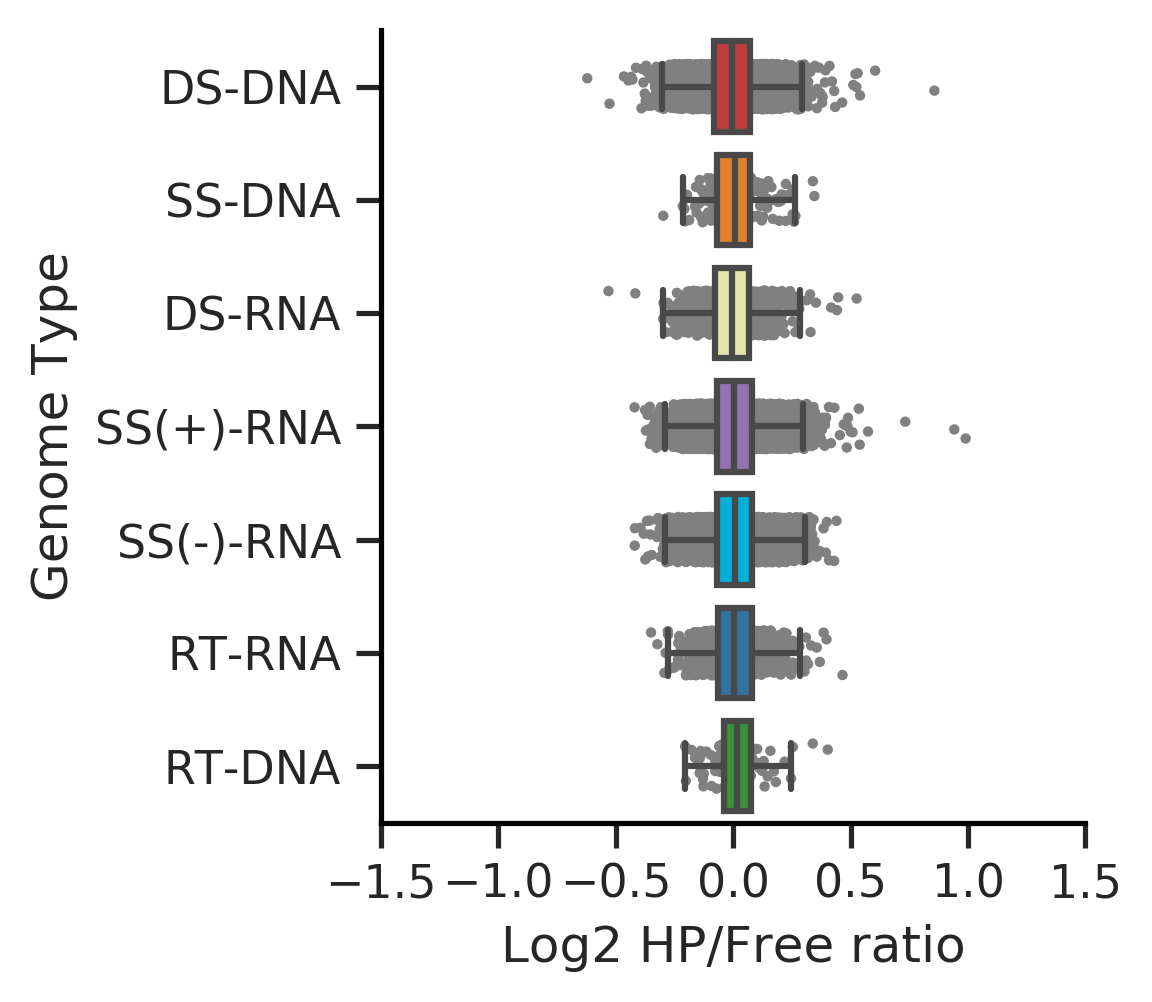

In [89]:
tmp = df_clust_total[4].copy()
tmp = tmp.reset_index()
tmp['HP/Free'] = tmp['count_HP']- tmp['count_Free']

sns.set(rc={'figure.figsize':(4,3.5),"figure.dpi":300, 'savefig.dpi':300,'axes.facecolor':'white','axes.spines.left': True,
        'axes.spines.bottom': True, 'axes.edgecolor': 'black','ytick.left': True,'xtick.bottom': True, 'font.family': ['Helvetica']}) 

tmp['ID'] = tmp['species'].apply(lambda x: x.split('|')[2])
tmp = pd.merge(tmp, df_tax, on='ID', how='left')


tmp = tmp.set_index('Genome Type').loc[teams,:].reset_index()

ax = sns.stripplot(y='Genome Type', x='HP/Free', data=tmp, color="grey", jitter=0.2, size=2.5, zorder = 0)
ax = sns.boxplot(y='Genome Type', x='HP/Free', data=tmp, showfliers = False)

ax.set_yticklabels(['DS-DNA', 'SS-DNA','DS-RNA', 'SS(+)-RNA','SS(-)-RNA','RT-RNA','RT-DNA'],rotation =0)
ax.set_xlabel('Log2 HP/Free ratio')

#     print(patch.get_facecolor())
color = [(0.7534313725490196, 0.23872549019607847, 0.24166666666666664, 1), 
         (0.8818627450980391, 0.5053921568627451, 0.17303921568627467, 1),
         (236/264, 236/264, 180/264, 1),
         (0.5784313725490194, 0.446078431372549, 0.6990196078431372, 1),
         (0, 181/264, 226/264, 1),
         (0.19460784313725488, 0.45343137254901944, 0.632843137254902, 1), 
         (0.22941176470588232, 0.5705882352941177, 0.22941176470588232, 1) 
        ]

for i,patch in enumerate(ax.artists):
    patch.set_facecolor(color[i])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.xaxis.set_ticks_position('none') 
ax.set_xlim(-1.5,1.5)
ax.set_xticks([-1.5, -1, -0.5, 0,0.5,1, 1.5])
ax.grid(False)


plt.rcParams['pdf.use14corefonts'] = True
plt.tight_layout()
plt.savefig(savedir + 'Figure2(Balt,Pollog2FC).pdf')

plt.show()